# Avian Disease Prediction Analysis based on Government dashboard and external resources

This study will focus on using data from Death counts, 6 diagnosis: including Egg Peritonitis & Salpingiti, Colisepticaemia Yolk sac infection/ omphalitis, Broiler ascites, Red Mite, Marek's Disease and other resources such as weather, temperature, etc. based on regions to detect early case of outbreaks of Avian Disease on poultry and suggest prevention methods based on these findings.

Avian Disease dashboard: https://public.tableau.com/app/profile/siu.apha/viz/AvianDashboard/Overview

## Feature Engineering

### Importing Libraries

In [75]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

### Creating new features

In [2]:
# Read the collected dataset
df = pd.read_excel ('AvianDataset.xlsx', sheet_name = 'Number')

# Replace \n with a space for clearer column names
pd.set_option('display.max_colwidth', None)
df.columns = df.columns.str.replace('\n', ' ')
df

,No.,Month,Year,0-7 days,Immature,Adult,Scotland,East of England,South West,Wales,...,Min_temp South East,Days of frost South East,Hours of rainfall South East,Hours of sunshine South East,Precipitation Scotland,Precipitation Southwest,Precipitation Wales,Precipitation West Midlands,Precipitation South East,Total death
0,1,1,2012,0,0,3,0,2,0,0,...,2.8,8.4,48.7,73.2,156.2,84.1,92.3,41.9,49.7,3
1,2,2,2012,0,1,2,2,0,0,0,...,0.3,14.5,19.3,83.7,81.0,40.6,46.1,20.5,19.9,3
2,3,3,2012,0,0,2,0,0,0,2,...,3.3,2.3,26.6,174.5,43.5,31.3,23.0,30.8,27.9,2
3,4,4,2012,0,1,3,0,0,0,0,...,3.4,4.4,133.8,155.7,124.1,153.7,98.8,125.4,130.0,4
4,5,5,2012,0,2,0,0,0,0,0,...,8.1,0.0,42.7,191.6,78.1,51.2,59.5,44.9,41.6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,8,2024,0,0,2,0,2,0,0,...,13.0,0.0,41.0,209.2,176.3,53.4,87.3,23.7,32.8,2
152,153,9,2024,0,1,1,1,0,0,0,...,10.6,0.0,157.4,129.8,91.1,168.7,146.2,122.1,141.3,2
153,154,10,2024,0,0,2,0,0,0,2,...,8.4,0.1,91.2,88.0,117.1,124.5,104.5,61.1,79.7,2
154,155,11,2024,0,0,0,0,0,0,0,...,5.0,5.7,87.9,54.0,77.1,122.2,69.2,51.4,73.5,0


In [3]:
# Create a copy of current dataset for feature engineering

df2 = df.copy()

#### Sinusoidal encoding

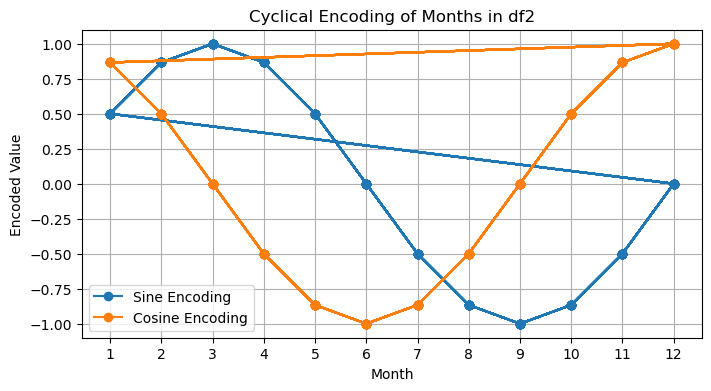

                Month_sin     Month_cos  Total death
Month_sin    1.000000e+00 -1.303138e-17    -0.250631
Month_cos   -1.303138e-17  1.000000e+00    -0.182153
Total death -2.506313e-01 -1.821526e-01     1.000000


In [4]:
# Encode using the sine/cosine to implement month cyclical encoding

df2['Month_sin'] = np.sin(2 * np.pi * df2['Month'] / 12)
df2['Month_cos'] = np.cos(2 * np.pi * df2['Month'] / 12)

# Plot sine and cosine encodings
plt.figure(figsize=(8, 4))
plt.plot(df2['Month'], df2['Month_sin'], label='Sine Encoding', marker='o')
plt.plot(df2['Month'], df2['Month_cos'], label='Cosine Encoding', marker='o')
plt.xlabel("Month")
plt.ylabel("Encoded Value")
plt.title("Cyclical Encoding of Months in df2")
plt.xticks(ticks=np.arange(1, 13))  # Ensure months are properly spaced
plt.legend()
plt.grid()
plt.show()

# Check the correlation with "Total death"
print(df2[['Month_sin', 'Month_cos', 'Total death']].corr())

We created Month_sin and Month_cos to preserve the cyclical nature of months: 1 to 12 and back to 1 since they are actually adjacent in time, however they don't seem to correlate well with our response variable "Total death".

In the meantime, we will keep them and apply feature importance to determine if we should drop/keep later.

#### Creating lagged features

##### For high-correlated features

In [5]:
# Calculate absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs().sort_values(ascending=False)

# Select features with correlation > 0.4, excluding "Total death"
high_corr_features = correlations[correlations.index != "Total death"][correlations > 0.4]

# Convert to dictionary with rounded values
high_corr_features_dict = high_corr_features.round(3).to_dict()

high_corr_features_dict

{'Immature': 0.842,
 'Scotland': 0.693,
 'Adult': 0.673,
 'East of England': 0.579,
 'Colisepticaemia': 0.522,
 'West Midlands': 0.509,
 'South East': 0.481,
 'Broiler ascites': 0.461,
 'Egg Peritonitis & Salpingitis': 0.444,
 'Red Mite': 0.426,
 'Yolk sac infection/ omphalitis': 0.42}

We filtered the correlation features > 0.4 with "Total death" to see which one to apply lagged method

In [6]:
high_corr_features = correlations[correlations.index != "Total death"][correlations > 0.4].index.tolist()

# Define the number of lag periods
lag_periods = [1, 3, 6, 12]

# Create lagged features for selected high-correlation variables
for feature in high_corr_features:
    for lag in lag_periods:
        df2[f"{feature}_lag{lag}"] = df2[feature].shift(lag)

df2.head()

,No.,Month,Year,0-7 days,Immature,Adult,Scotland,East of England,South West,Wales,...,Egg Peritonitis & Salpingitis_lag6,Egg Peritonitis & Salpingitis_lag12,Red Mite_lag1,Red Mite_lag3,Red Mite_lag6,Red Mite_lag12,Yolk sac infection/ omphalitis_lag1,Yolk sac infection/ omphalitis_lag3,Yolk sac infection/ omphalitis_lag6,Yolk sac infection/ omphalitis_lag12
0,1,1,2012,0,0,3,0,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,2012,0,1,2,2,0,0,0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,3,3,2012,0,0,2,0,0,0,2,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,4,4,2012,0,1,3,0,0,0,0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
4,5,5,2012,0,2,0,0,0,0,0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN


In [7]:
# Select only lagged columns
lagged_columns = [col for col in df2.columns if "_lag" in col]

# Compute correlations of lagged features with "Total death"
lagged_correlations = df2[lagged_columns].corrwith(df2["Total death"]).sort_values(ascending=False)

# Display correlation values
lagged_correlations.abs().sort_values(ascending=False)

Immature_lag1                           0.540826
Scotland_lag1                           0.443475
East of England_lag12                   0.393312
South East_lag1                         0.344654
Broiler ascites_lag1                    0.340297
Immature_lag3                           0.325353
South East_lag12                        0.307384
West Midlands_lag1                      0.297788
West Midlands_lag12                     0.293651
Immature_lag12                          0.284477
East of England_lag1                    0.283931
Yolk sac infection/ omphalitis_lag1     0.267322
Red Mite_lag1                           0.265040
West Midlands_lag3                      0.258020
Broiler ascites_lag12                   0.252047
Scotland_lag3                           0.248053
Colisepticaemia_lag12                   0.240462
Adult_lag1                              0.223865
Colisepticaemia_lag3                    0.211049
South East_lag3                         0.203386
Adult_lag12         

In [8]:
# Remove lagged features with correlation < 0.4
filtered_lagged_features = lagged_correlations[lagged_correlations >= 0.4]

# Get the feature names
filtered_lagged_features_names = filtered_lagged_features.index.tolist()

filtered_lagged_features_names

['Immature_lag1', 'Scotland_lag1']

##### For low-correlated features

In [9]:
import pandas as pd

# Calculate absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs().sort_values()

# Identify features with correlation lower than 0.4
low_corr_features = correlations[correlations < 0.4].index.tolist()

# Create lagged features (1, 3, 6, and 12 months)
for col in low_corr_features:
    df2[f'{col}_lag1'] = df2[col].shift(1)  # 1-month lag
    df2[f'{col}_lag3'] = df2[col].shift(3)  # 3-month lag
    df2[f'{col}_lag6'] = df2[col].shift(6)  # 6-month lag
    df2[f'{col}_lag12'] = df2[col].shift(12)  # 12-month lag

# Compute correlations for original and lagged features
new_corr = df2.corr()["Total death"]

# Create DataFrame for comparison (compare with their Original value)
df_comparison = pd.DataFrame({
    "Feature": low_corr_features,
    "Original Corr": correlations[low_corr_features].values,
    "Lag1 Corr": new_corr[[col+"_lag1" for col in low_corr_features]].values,
    "Lag3 Corr": new_corr[[col+"_lag3" for col in low_corr_features]].values,
    "Lag6 Corr": new_corr[[col+"_lag6" for col in low_corr_features]].values,
    "Lag12 Corr": new_corr[[col+"_lag12" for col in low_corr_features]].values,
})

# Preserve original values and filter only rows where at least one lagged correlation increased
df_filtered = df_comparison[
    (df_comparison["Lag1 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag3 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag6 Corr"] > df_comparison["Original Corr"]) |
    (df_comparison["Lag12 Corr"] > df_comparison["Original Corr"])
]

# Identify lagged features to remove (<10% correlation increase)
features_to_remove = []
for col in ["Lag1 Corr", "Lag3 Corr", "Lag6 Corr", "Lag12 Corr"]:
    features_to_remove.extend(df_filtered[df_filtered[col] <= df_filtered["Original Corr"] * 1.1]["Feature"]
                              .apply(lambda x: f"{x}_{col.split()[0].lower()}"))

# Drop weak lagged features from df2
df2 = df2.drop(columns=features_to_remove, errors="ignore")


df_filtered = df_filtered.sort_values("Original Corr", ascending=False)
print(df_filtered.to_string(index=False))
print(f"Removed lagged features with <10% correlation improvement. Remaining features: {df2.shape[1]}")
print(f"Updated dataset shape: {df2.shape}")

                            Feature  Original Corr  Lag1 Corr  Lag3 Corr  Lag6 Corr  Lag12 Corr
                 West Midlands_lag1       0.297788   0.338244   0.175410   0.026506    0.256440
Yolk sac infection/ omphalitis_lag1       0.267322   0.267790   0.050058   0.039902   -0.068396
                  Max_temp Scotland       0.255069   0.271180   0.069416  -0.300373    0.208008
              Broiler ascites_lag12       0.252047   0.284999  -0.051892  -0.081799   -0.053943
                          Month_sin       0.250631  -0.125987   0.185343   0.262988   -0.206777
                 Max_temp Southwest       0.243171   0.249262   0.044811  -0.333621    0.212402
                     Max_temp Wales       0.242828   0.253538   0.054667  -0.329929    0.208230
           Max_temp East of England       0.242572   0.246111   0.030660  -0.336959    0.231181
                Max_temp South East       0.240114   0.245938   0.037909  -0.336371    0.221139
             Max_temp West Midlands     

In [10]:
# Compute absolute correlations with "Total death"
correlations = df2.corr()["Total death"].abs()

# Identify lagged columns with correlation < 0.4
weak_features = [col for col in df2.columns if "lag" in col and correlations[col] < 0.4]

# Drop weakly correlated lagged columns from df2
df2 = df2.drop(columns=weak_features, errors="ignore")

# Get column names containing "lagged"
lagged_column_names = [col for col in df2.columns if "lag" in col]

print(f"Removed lagged columns with correlation <0.4. Remaining features: {df2.shape[1]}")
print(f"Updated dataset shape: {df2.shape}")
lagged_column_names

Removed lagged columns with correlation <0.4. Remaining features: 69
Updated dataset shape: (156, 69)


['Immature_lag1',
 'Scotland_lag1',
 'Days of frost East of England_lag6',
 'Days of frost Wales_lag6',
 'Days of frost South East_lag6',
 'Days of frost Southwest_lag6',
 'Days of frost West Midlands_lag6']

##### Filtering lagged features based on correlation

In [11]:
df3 = df2.copy()

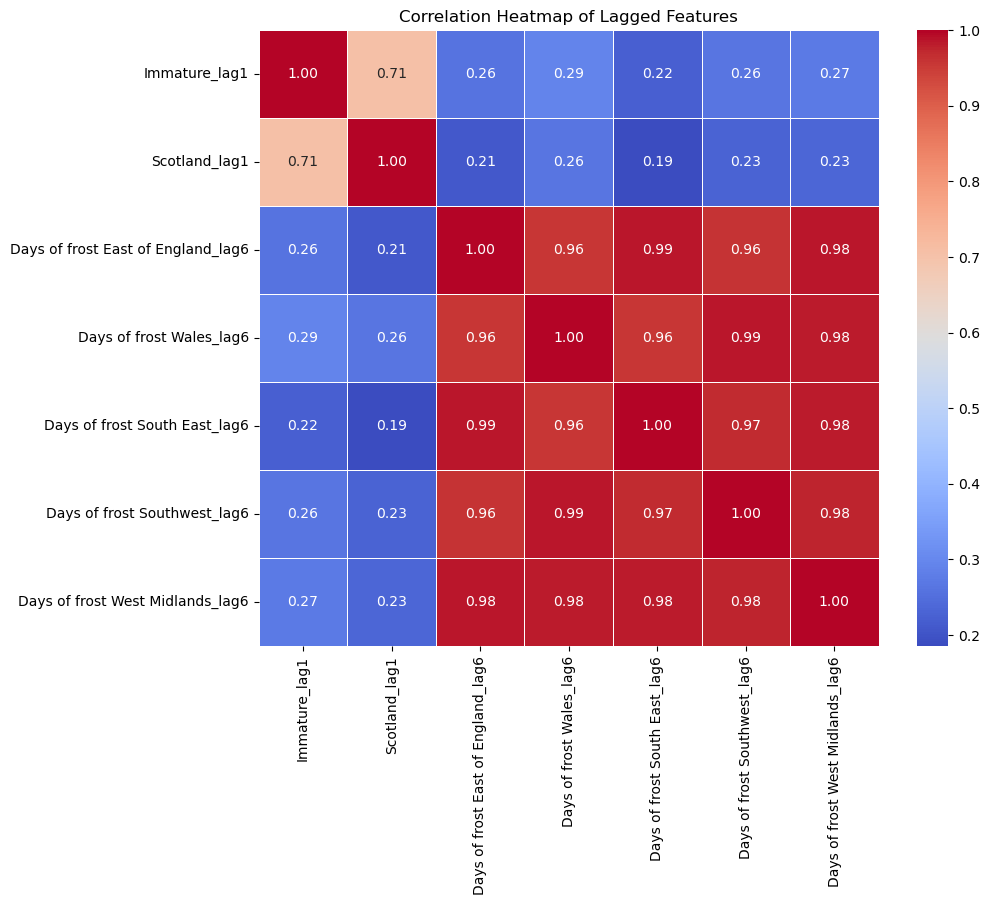

In [12]:
# Identify all lagged columns
lagged_columns = [col for col in df3.columns if "lag" in col]

# Create dataframe containing only lagged columns
df_lagged = df3[lagged_columns]  # Ensure df_lagged is properly defined

# Compute correlation matrix for lagged features
lag_corr_matrix = df_lagged.corr()

# Plot heatmap for visual representation
plt.figure(figsize=(10, 8))
sns.heatmap(lag_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Lagged Features")
plt.show()

1/ Since Immature_lag1 and Scotland_lag1 are highly correlated with each other

=> We will remove both, because we have already have Original with much higher correlation.

2/ Since all lags for days of frost are highly correlated with each other, we only keep the one with the highest correlation with Total death and remove the rest.

=> Keep Days of frost East of England_lag6

In [13]:
# Remove specific columns
df2 = df2.drop(['Immature_lag1', 'Scotland_lag1'], axis=1)

In [14]:
# Identify all columns with "lag" in the name
lagged_columns = [col for col in df2.columns if "lag" in col]

# Remove all lagged columns except 'Days of frost East of England_lag6'
columns_to_keep = ['Days of frost East of England_lag6']
df2 = df2.drop(columns=[col for col in lagged_columns if col not in columns_to_keep])

# Check the resulting dataframe
print(df2.head())

   No.  Month  Year  0-7 days  Immature  Adult  Scotland  East of England  \
0    1      1  2012         0         0      3         0                2   
1    2      2  2012         0         1      2         2                0   
2    3      3  2012         0         0      2         0                0   
3    4      4  2012         0         1      3         0                0   
4    5      5  2012         0         2      0         0                0   

   South West  Wales  ...  Hours of sunshine South East  \
0           0      0  ...                          73.2   
1           0      0  ...                          83.7   
2           0      2  ...                         174.5   
3           0      0  ...                         155.7   
4           0      0  ...                         191.6   

   Precipitation Scotland  Precipitation Southwest  Precipitation Wales  \
0                   156.2                     84.1                 92.3   
1                    81.0       

In [15]:
# Fill NaN of lagged features with future trends

df2["Days of frost East of England_lag6"] = df2["Days of frost East of England_lag6"].fillna(method='bfill')

#### Apply PCA to Weather features only (since it's highly correlated with each other)

In [16]:
df3 = df2.copy()

In [17]:
df3.shape

(156, 63)

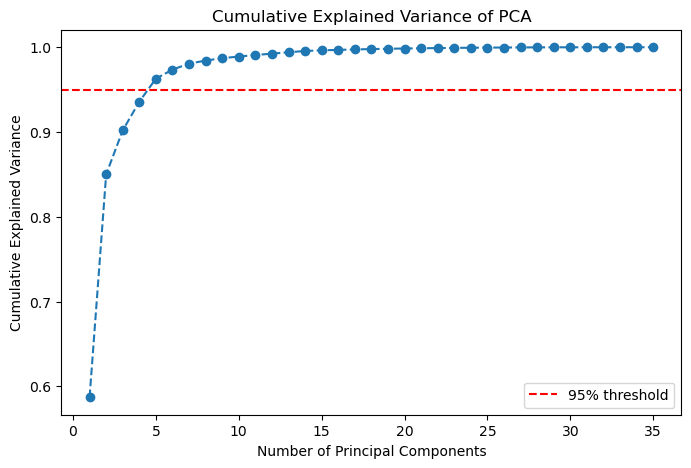

In [18]:
# Select columns based on specified keywords, excluding 'lag'
weather_keywords = ["Min", "Max", "Hours", "Days of frost", "Precipitation"]
weather_columns = [col for col in df3.columns if any(keyword in col for keyword in weather_keywords) and "lag" not in col]

# Extract the subset of relevant features
df_selected = df3[weather_columns]

# Handle missing values (imputation)
df_selected_clean = df_selected.copy()
df_selected_clean.fillna(df_selected_clean.mean(), inplace=True)  # Impute with column mean

# Standardize the selected features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected_clean)

# Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance of PCA")
plt.legend()
plt.show()

In [19]:
# Apply PCA with 5 components
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_scaled)

# Convert PCA results into a DataFrame with new column names
df_pca = pd.DataFrame(df_pca, columns=["PCA_Weather1", "PCA_Weather2", "PCA_Weather3", "PCA_Weather4", "PCA_Weather5"])

# Get explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Display explained variance for each PCA_Weather component
for i, variance in enumerate(explained_variance, 1):
    print(f"PCA_Weather{i}: {variance:.4f} ({variance * 100:.2f}%)")

PCA_Weather1: 0.5872 (58.72%)
PCA_Weather2: 0.2628 (26.28%)
PCA_Weather3: 0.0520 (5.20%)
PCA_Weather4: 0.0338 (3.38%)
PCA_Weather5: 0.0272 (2.72%)


#### Clustering based on final dataset

In [20]:
df4 = df3.copy()

In [21]:
weather_column_count_alt = sum(any(keyword in col for keyword in weather_keywords) and "lag" not in col for col in df3.columns)
print(f"Number of weather-related columns (excluding 'lag'): {weather_column_count_alt}")

Number of weather-related columns (excluding 'lag'): 35


In [22]:
df4.shape

(156, 63)

We currently have a dataset of 156 rows and 63 columns that still includes all Weather features: 

"Min/Max temperature

Days of frost

Hours of sunshine/rainfall

Precipitation"

Those features are highly correlated to each other, which we have applied PCA on those features to reduce from 35 to only 5 components.

=> We will replace all 35 with only 5 columns for the final Dataset before applying Clustering and Classification models.

In [23]:
# Select columns that do not contain weather-related metrics (except lagged ones)
filtered_columns = [col for col in df3.columns if not any(keyword in col for keyword in weather_keywords) or "lag" in col]

# Create a new DataFrame excluding those columns
df_filtered = df4[filtered_columns]

print(f"Number of columns retained: {df_filtered.shape[1]}")

# Merge filtered DataFrame with existing PCA components
df4 = pd.concat([df_filtered.reset_index(drop=True), df_pca], axis=1)

# Move "Total death" to the last column
df4 = df4[[col for col in df4.columns if col != "Total death"] + ["Total death"]]

df4.columns

Number of columns retained: 28


Index(['No.', 'Month', 'Year', '0-7 days', 'Immature', 'Adult', 'Scotland',
       'East of England', 'South West', 'Wales', 'West Midlands', 'South East',
       'Egg Peritonitis & Salpingitis', 'Colisepticaemia',
       'Yolk sac infection/ omphalitis', 'Broiler ascites', 'Red Mite',
       'Neoplasm', 'Marek's Disease', 'Slaughter (Million birds)',
       'Production (Thousand tonnes)', 'Eggs Import (Million Dozen)',
       'Eggs Export (Million Dozen)', 'Eggs RPI average price (per dozen)',
       'Month_sin', 'Month_cos', 'Days of frost East of England_lag6',
       'PCA_Weather1', 'PCA_Weather2', 'PCA_Weather3', 'PCA_Weather4',
       'PCA_Weather5', 'Total death'],
      dtype='object')

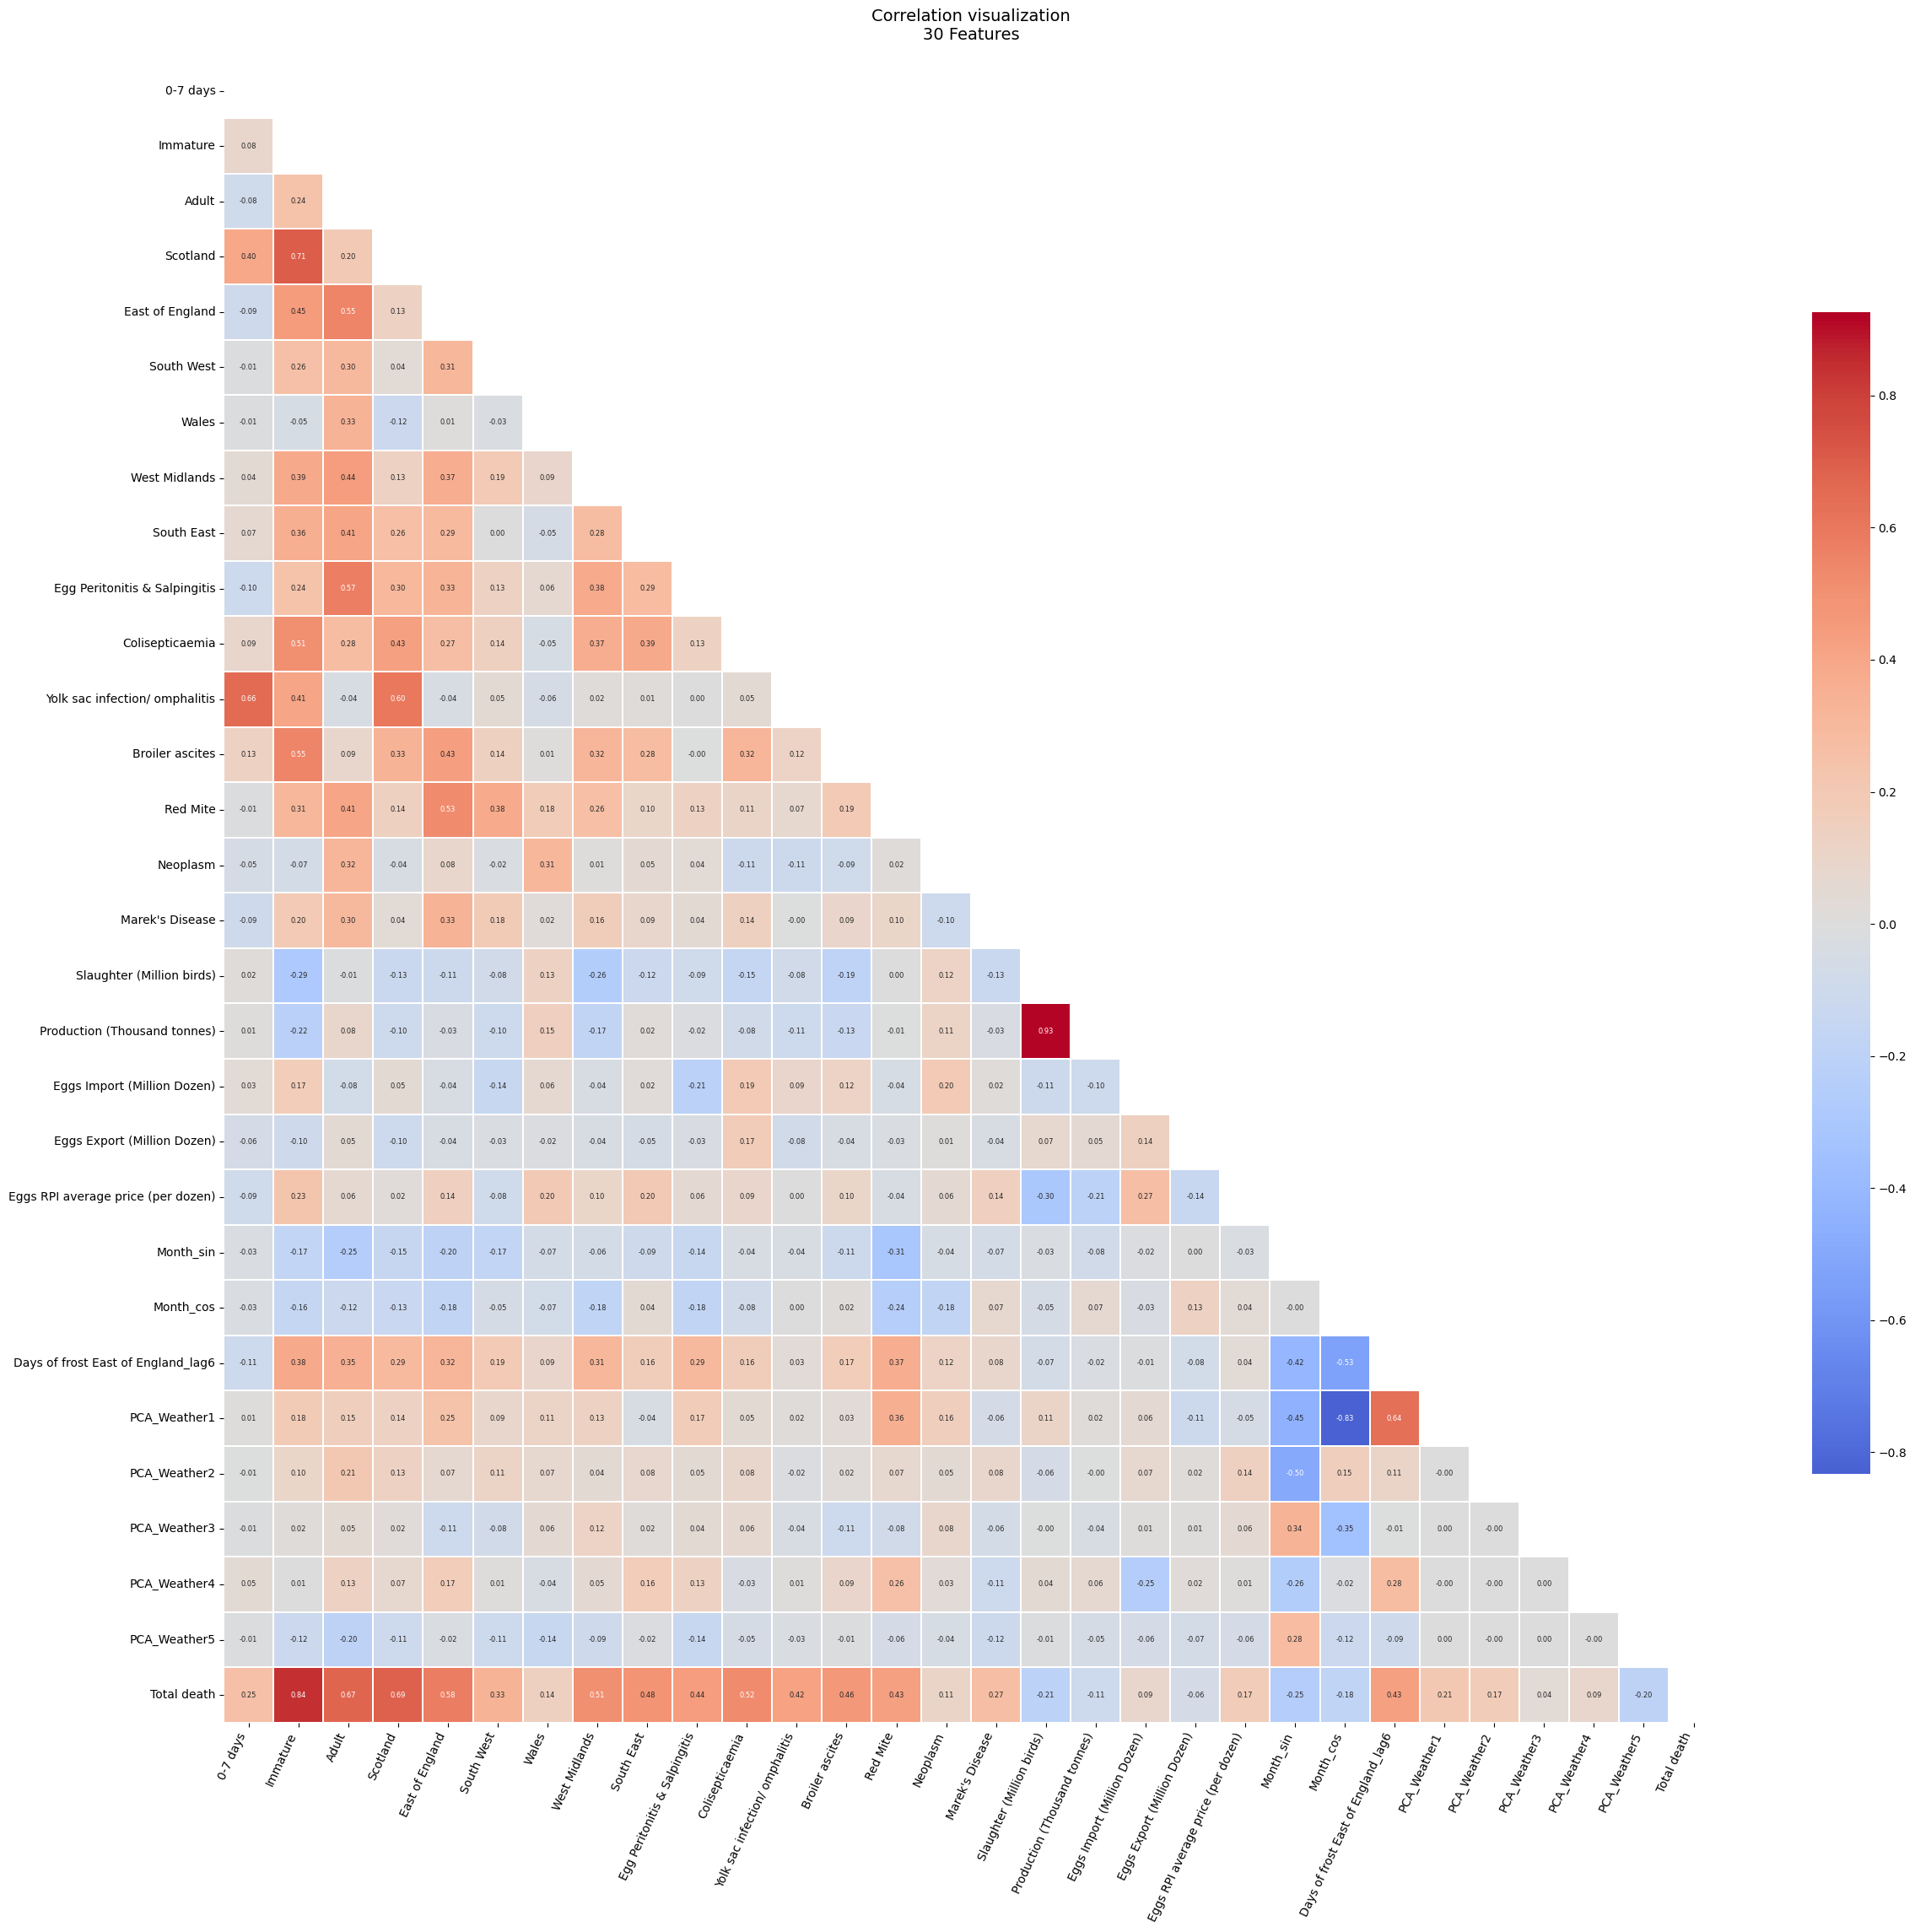

In [24]:
def correlation_visual(df, exclude_cols=3, correlation_threshold=0.7, figsize=(25, 23)):
   
    numeric_cols = df.select_dtypes(include=['number']).columns
    analyzed_cols = numeric_cols[exclude_cols:]
    corr_matrix = df[analyzed_cols].corr()
    
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    
    # Create heatmap 
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask,
                    annot_kws={'size': 6}, linewidths=0.1, cbar_kws={'shrink': 0.7})
    
    plt.xticks(rotation=65, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(f'Correlation visualization\n{len(analyzed_cols)} Features', 
              pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

correlation_results = correlation_visual(df4)

##### Final filtering

We only remove Production (Thousand tonnes) since it's highly correlated with Slaughter (Million birds.

Even though we have other higher correlation pairs, their categories are different and might lead to better explanation for Total death.

=> We will keep the remaining for testing and the final dataset will be as below.

In [25]:
df4 = df4.drop(columns=["Production (Thousand tonnes)"])

(156, 32)

In [102]:
df5 = df4.copy()

In [104]:
import pandas as pd
import numpy as np

def remove_highly_correlated_features(df, response_var, threshold=0.5):
    # Select explanatory features (from column index 3 to -1)
    X = df.iloc[:, 3:-1]
    y = df[response_var]

    # Compute correlation matrix
    corr_matrix = X.corr().abs()

    # Sort features by correlation with response variable
    response_corr = X.corrwith(y).abs().sort_values(ascending=False)

    # Track removed features
    removed_features = set()
    
    for feature in response_corr.index:
        if feature in removed_features:
            continue  # Skip already removed features
        
        # Find highly correlated features (≥ threshold)
        correlated_features = corr_matrix.loc[feature, corr_matrix.loc[feature] >= threshold].index.tolist()
        
        # Remove all correlated features except the strongest one
        for correlated_feature in correlated_features:
            if correlated_feature != feature:  # Don't remove the main feature
                if response_corr[correlated_feature] < response_corr[feature]:  
                    removed_features.add(correlated_feature)

    # Keep only uncorrelated features
    remaining_features = [feature for feature in X.columns if feature not in removed_features]
    df_filtered = df[remaining_features + [response_var]]  # Retain response variable

    print(f"Removed features: {removed_features}")
    print(f"Remaining features: {len(remaining_features)}")

    return df_filtered

df_filtered = remove_highly_correlated_features(df5, "Total death")

Removed features: {'Broiler ascites', 'Scotland', 'Egg Peritonitis & Salpingitis', 'PCA_Weather1', 'Colisepticaemia', '0-7 days', 'Month_cos', 'East of England'}
Remaining features: 20


In [109]:
df4 = df_filtered

In [110]:
filtered_df = df4.copy()

In [111]:
filtered_df.shape

(156, 21)

#### Clustering

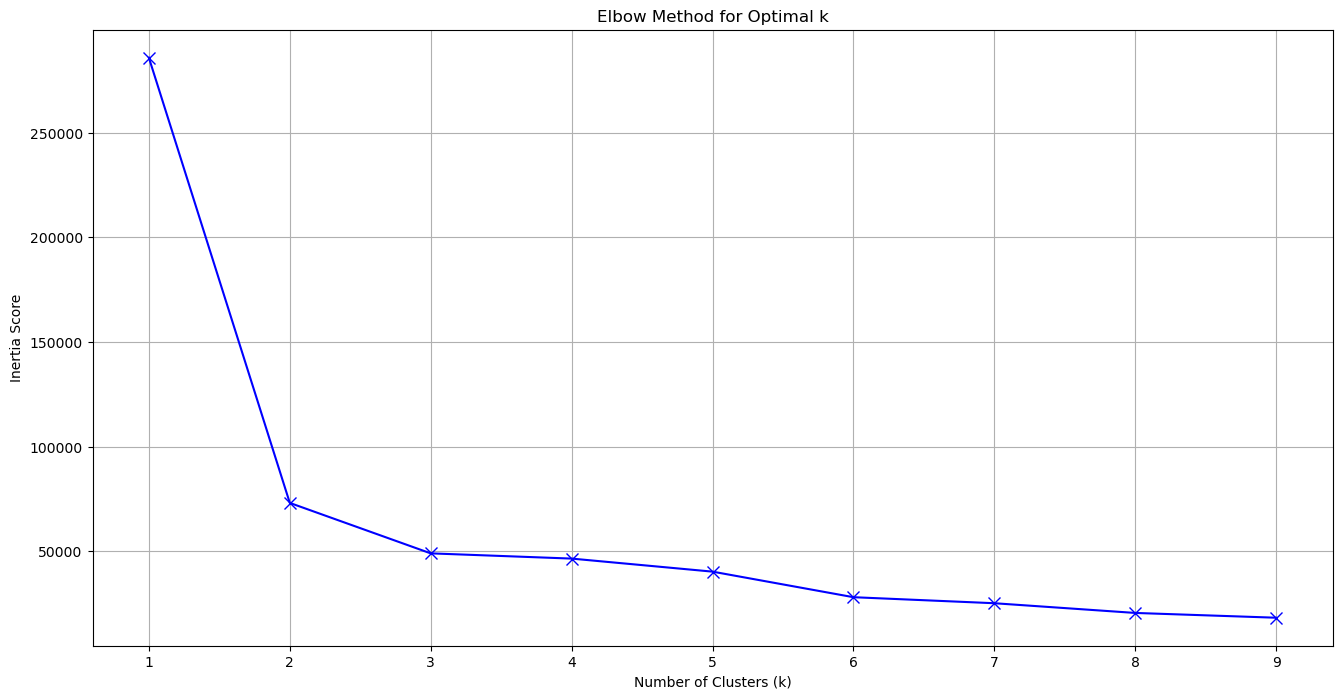

In [112]:
# Exclude the first 3 columns
filtered_df_kmeans = filtered_df.iloc[:, 3:-5]

# Perform the Elbow Method
inertia_scores = []
kmeans_params = range(1, 10)

for k in kmeans_params:
    model = KMeans(n_clusters=k, random_state=0) 
    model.fit(filtered_df_kmeans)  
    inertia_scores.append(model.inertia_)

# Plot Elbow Method analysis
plt.figure(figsize=(16, 8))
plt.plot(kmeans_params, inertia_scores, "bx-", markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia Score")
plt.title("Elbow Method for Optimal k")
plt.grid(True) 
plt.show()

In [113]:
# Choose the optimal k 
optimal_k = 2

# Train K-Means with the optimal number of clusters
model = KMeans(n_clusters=optimal_k, random_state=0)
model.fit(filtered_df_kmeans)

# Assign cluster labels to the dataset
filtered_df_kmeans["Cluster"] = model.predict(filtered_df_kmeans)

# Check how many samples are in each cluster
print(filtered_df_kmeans["Cluster"].value_counts())

Cluster
0    80
1    76
Name: count, dtype: int64


In [114]:
cluster_0_data = filtered_df_kmeans[filtered_df_kmeans["Cluster"] == 0]
print(cluster_0_data)

            Wales  West Midlands  South East  Yolk sac infection/ omphalitis  \
yearMonth                                                                      
2015-07-01      0              0           0                               0   
2015-10-01      0              0           0                               0   
2016-01-01      0              0           1                               1   
2016-03-01      0              0           0                               2   
2016-04-01      0              0           0                               1   
...           ...            ...         ...                             ...   
2022-03-01      0              0           0                               0   
2022-04-01      1              0           0                               0   
2022-05-01      0              0           0                               0   
2022-06-01      0              0           0                               0   
2022-07-01      0              0        

In [115]:
cluster_1_data = filtered_df_kmeans[filtered_df_kmeans["Cluster"] == 1]
print(cluster_1_data)

            Wales  West Midlands  South East  Yolk sac infection/ omphalitis  \
yearMonth                                                                      
2012-01-01      0              0           1                               0   
2012-02-01      0              1           0                               0   
2012-03-01      2              0           0                               0   
2012-04-01      0              1           0                               0   
2012-05-01      0              2           0                               0   
...           ...            ...         ...                             ...   
2024-08-01      0              0           0                               0   
2024-09-01      0              0           0                               0   
2024-10-01      2              0           0                               0   
2024-11-01      0              0           0                               0   
2024-12-01      0              0        

### Determine the threshold for Total death (using KBin Discretize and Mean/std)

In [116]:
def threshold_determination(df, column_name, n_bins=3):

    strategies = ["kmeans", "uniform", "quantile"]
    bin_labels = {0: "Low", 1: "Medium", 2: "High"}
    
    bin_counts_summary = {}

    # Apply KBinsDiscretizer-based methods
    for strategy in strategies:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        df[f"Death Category ({strategy})"] = discretizer.fit_transform(df[[column_name]]).astype(int)
        
        df[f"Death Category ({strategy})"] = df[f"Death Category ({strategy})"].map(bin_labels)
        
        bin_counts_summary[strategy] = df[f"Death Category ({strategy})"].value_counts()

    # **Apply Mean/Std-Based Binning**
    mean_death = df[column_name].mean()
    std_death = df[column_name].std()
    low_thresh = mean_death - std_death
    high_thresh = mean_death + std_death

    def categorize_death(val):
        if val == 0:
            return 'Low'
        elif val > high_thresh:
            return 'High'
        else:
            return 'Medium'

    df["Death Category (mean/std)"] = df[column_name].apply(categorize_death)

    # Store bin counts for mean/std method
    bin_counts_summary["mean/std"] = df["Death Category (mean/std)"].value_counts()
    df_bin_counts = pd.DataFrame(bin_counts_summary).fillna(0).astype(int)  # Fill NaN and convert to int
    
    return df_bin_counts

df_bin_counts = threshold_determination(filtered_df, "Total death", n_bins=3)
print("\nComparison of Binning Strategies:\n")
display(df_bin_counts)


Comparison of Binning Strategies:



,kmeans,uniform,quantile,mean/std
High,7,3,57,20
Low,117,136,42,42
Medium,32,17,57,94


=> Since we have a huge gap between each category (except for quantile), we will first build the models and then apply balancing later to compare.

In [117]:
filtered_df.columns

Index(['Immature', 'Adult', 'South West', 'Wales', 'West Midlands',
       'South East', 'Yolk sac infection/ omphalitis', 'Red Mite', 'Neoplasm',
       'Marek's Disease', 'Slaughter (Million birds)',
       'Eggs Import (Million Dozen)', 'Eggs Export (Million Dozen)',
       'Eggs RPI average price (per dozen)', 'Month_sin',
       'Days of frost East of England_lag6', 'PCA_Weather2', 'PCA_Weather3',
       'PCA_Weather4', 'PCA_Weather5', 'Total death',
       'Death Category (kmeans)', 'Death Category (uniform)',
       'Death Category (quantile)', 'Death Category (mean/std)'],
      dtype='object')

## Classification models

### Using train_test_split

#### Testing the number of k values for KNN before applying Classifications

In [118]:
filtered_df2 = filtered_df.copy()


Class Mapping for Death Category (kmeans): {'High': 0, 'Low': 1, 'Medium': 2}

Class Mapping for Death Category (uniform): {'High': 0, 'Low': 1, 'Medium': 2}

Class Mapping for Death Category (quantile): {'High': 0, 'Low': 1, 'Medium': 2}

Class Mapping for Death Category (mean/std): {'High': 0, 'Low': 1, 'Medium': 2}


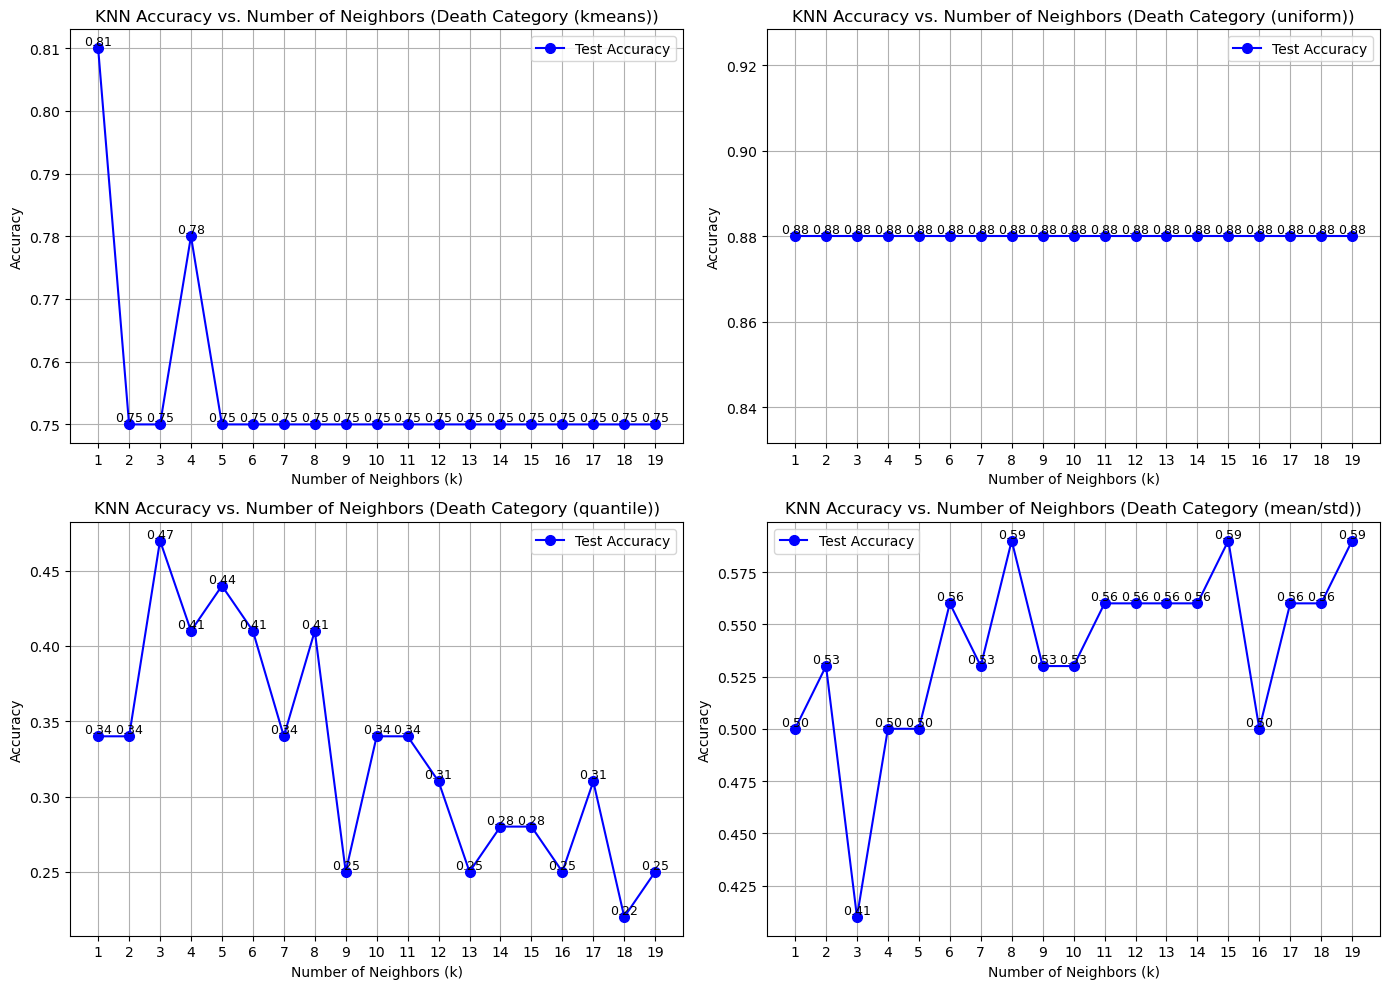

In [119]:
def determine_optimal_neighbors(df, y_columns, k_range=list(range(1, 20))):    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, y_var in enumerate(y_columns):
        # Encode target variable
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(df[y_var])
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:-5], y_encoded, test_size=0.2, stratify=y_encoded, random_state=0)

        # 🔹 Display class mapping
        class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        print(f"\nClass Mapping for {y_var}: {class_mapping}")

        accuracy_scores = []
        
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            acc = round(accuracy_score(y_test, y_pred), 2)
            accuracy_scores.append((k, acc))

        # Extract sorted k-values and accuracy scores
        k_values_sorted = [score[0] for score in sorted(accuracy_scores, key=lambda x: x[0])]
        accuracies_sorted = [score[1] for score in sorted(accuracy_scores, key=lambda x: x[0])]

        # 🔹 Plot
        ax = axes[idx]
        ax.plot(k_values_sorted, accuracies_sorted, marker='o', markersize=7, linestyle='-', color='b', label="Test Accuracy")

        # 🔹 Label accuracy values on the plot
        for k, acc in zi(k_values_sorted, accuracies_sorted):
            ax.text(k, acc, f"{acc:.2f}", fontsize=9, ha="center", va="bottom", color="black")

        ax.set_xlabel("Number of Neighbors (k)")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"KNN Accuracy vs. Number of Neighbors ({y_var})")
        ax.set_xticks(k_values_sorted)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Run with death categories
death_categories = ["Death Category (kmeans)", "Death Category (uniform)", "Death Category (quantile)", "Death Category (mean/std)"]
best_k_dict = determine_optimal_neighbors(filtered_df2, death_categories)

In [120]:
def compute_knn_metrics(df, y_var, k_list):
    y_encoded = LabelEncoder().fit_transform(df[y_var])
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:-5], y_encoded, test_size=0.2, stratify=y_encoded, random_state=0)

    results = []
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        acc = round(accuracy_score(y_test, y_pred), 2)
        prec = round(precision_score(y_test, y_pred, average='macro', zero_division=0), 2)
        rec = round(recall_score(y_test, y_pred, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_pred, average='macro', zero_division=0), 2)
        auc_roc = round(roc_auc_score(y_test, knn.predict_proba(X_test), multi_class="ovr"), 2) if hasattr(knn, "predict_proba") else None

        results.append([k, acc, prec, rec, f1, auc_roc])

    return pd.DataFrame(results, columns=["K", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])

In [134]:
# Calculate for Death Category (kmeans)
k_values_kmeans = [1, 4]
kmeans_category = "Death Category (kmeans)"

kmeans_metrics = compute_knn_metrics(filtered_df2, kmeans_category, k_values_kmeans)
print("\nMetrics for Kmeans:")
display(kmeans_metrics)


Metrics for Kmeans:


,K,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,1,0.81,0.82,0.78,0.79,0.79
1,4,0.78,0.76,0.70,0.70,0.81


Even though k = 1 has a better result, choosing only 1 can lead to overfitting

=> Therefore, we will choose k = 4 for Kmeans

In [135]:
# Calculate for Death Category (uniform)
k_values_uniform = list(range(1, 20))
uniform_category = "Death Category (uniform)"

uniform_metrics = compute_knn_metrics(filtered_df2, uniform_category, k_values_uniform)
print("\nMetrics for Uniform:")
display(uniform_metrics)


Metrics for Uniform:


,K,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,1,0.88,0.30,0.33,0.32,0.54
1,2,0.88,0.30,0.33,0.32,0.65
2,3,0.88,0.30,0.33,0.32,0.65
3,4,0.88,0.30,0.33,0.32,0.67
4,5,0.88,0.30,0.33,0.32,0.67
5,6,0.88,0.29,0.33,0.31,0.63
6,7,0.88,0.29,0.33,0.31,0.62
7,8,0.88,0.29,0.33,0.31,0.58
8,9,0.88,0.29,0.33,0.31,0.55
9,10,0.88,0.29,0.33,0.31,0.75


=> We will choose the one with the highest AUC-ROC: k = 5

In [136]:
# Calculate for Death Category (mean/std)
k_values_meanstd = [8, 15, 19]
meanstd_category = "Death Category (mean/std)"

meanstd_metrics = compute_knn_metrics(filtered_df2, meanstd_category, k_values_meanstd)
print("\nMetrics for Mean/Std:")
display(meanstd_metrics)


Metrics for Mean/Std:


,K,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,8,0.59,0.54,0.48,0.49,0.65
1,15,0.59,0.66,0.44,0.46,0.62
2,19,0.59,0.37,0.37,0.34,0.56


=> we will choose k = 15 for Mean/Std

In [137]:
# Summarize the findings:
# Define the final results
data = {
    "Death Category": ["Kmeans", "Uniform", "Quantile", "Mean/Std"],
    "K": [4, 5, 3, 15],
}

neighbor_results = pd.DataFrame(data)
print(neighbor_results)

  Death Category   K
0         Kmeans   4
1        Uniform   5
2       Quantile   3
3       Mean/Std  15


#### Perform Classification Model

In [125]:
def evaluate_classifiers(df, y_var, n_neighbors=7):

    # Encode target variable
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:-5], LabelEncoder().fit_transform(df[y_var]), test_size=0.2, stratify=df[y_var], random_state=0)

    # Define classifiers
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True)),
        ("GaussianNB", GaussianNB()),
        ("Random Forest", RandomForestClassifier()),
        ("KNN", KNeighborsClassifier(n_neighbors=n_neighbors)), 
        ("Gradient Boosting", GradientBoostingClassifier())
    ]

    results = []  

    # Train and evaluate classifiers
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)

        # Compute metrics
        acc = round(accuracy_score(y_test, y_hat), 2)
        prec = round(precision_score(y_test, y_hat, average='macro', zero_division=0), 2)
        recl = round(recall_score(y_test, y_hat, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_hat, average='macro', zero_division=0), 2)

        results.append([name, acc, prec, recl, f1])

    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    df_results[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

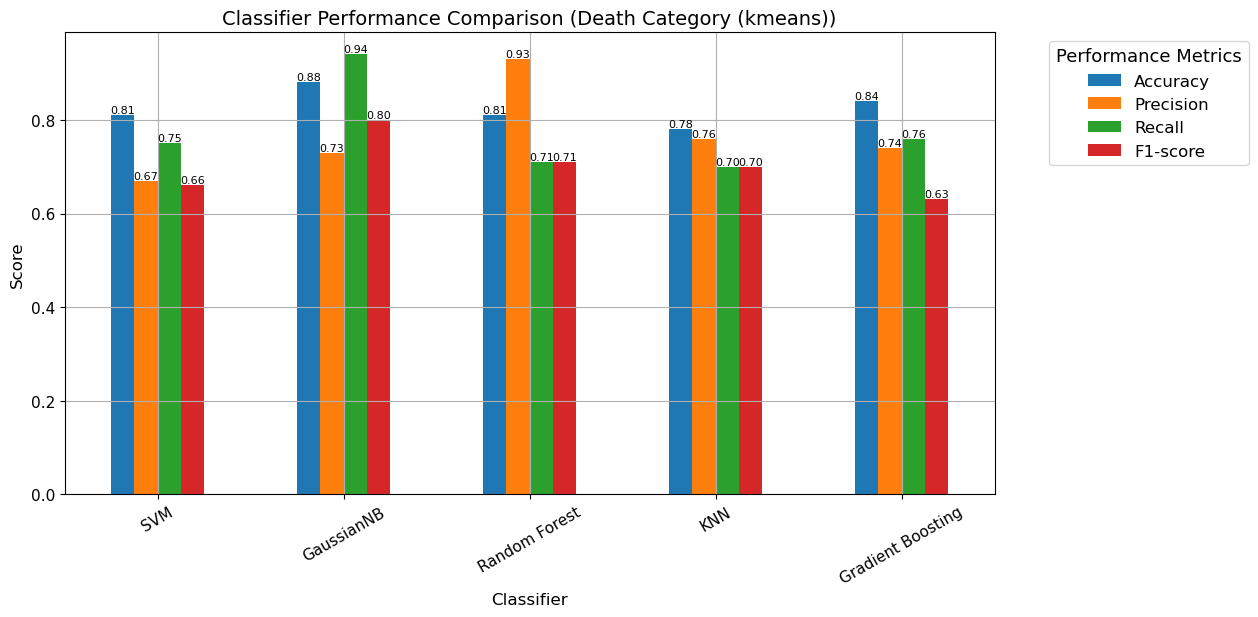

In [138]:
Kmeans_results = evaluate_classifiers(filtered_df2, "Death Category (kmeans)", n_neighbors=4)

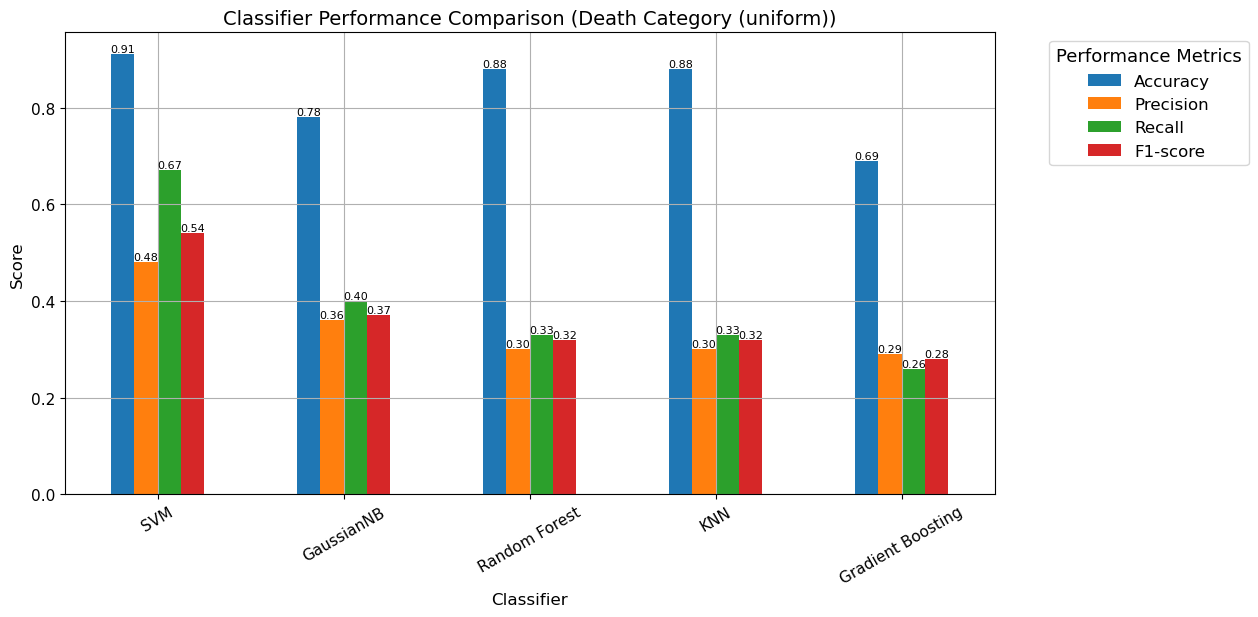

In [139]:
Uniform_results = evaluate_classifiers(filtered_df2, "Death Category (uniform)", n_neighbors=5)

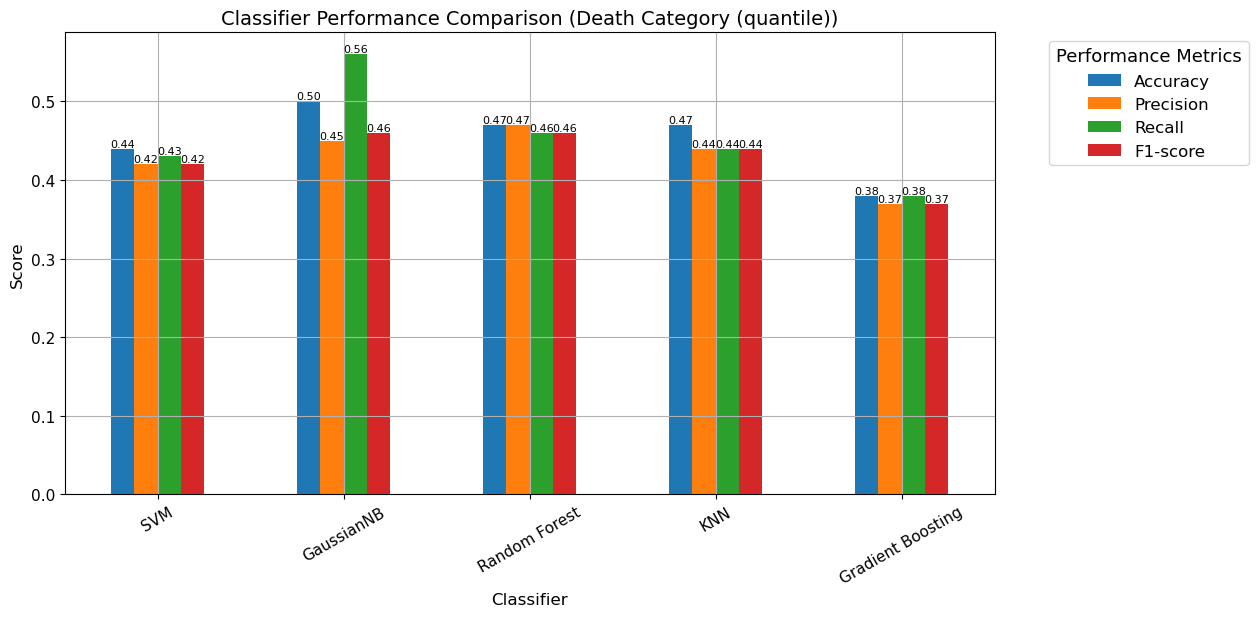

In [140]:
Quantile_results = evaluate_classifiers(filtered_df2, "Death Category (quantile)", n_neighbors=3)

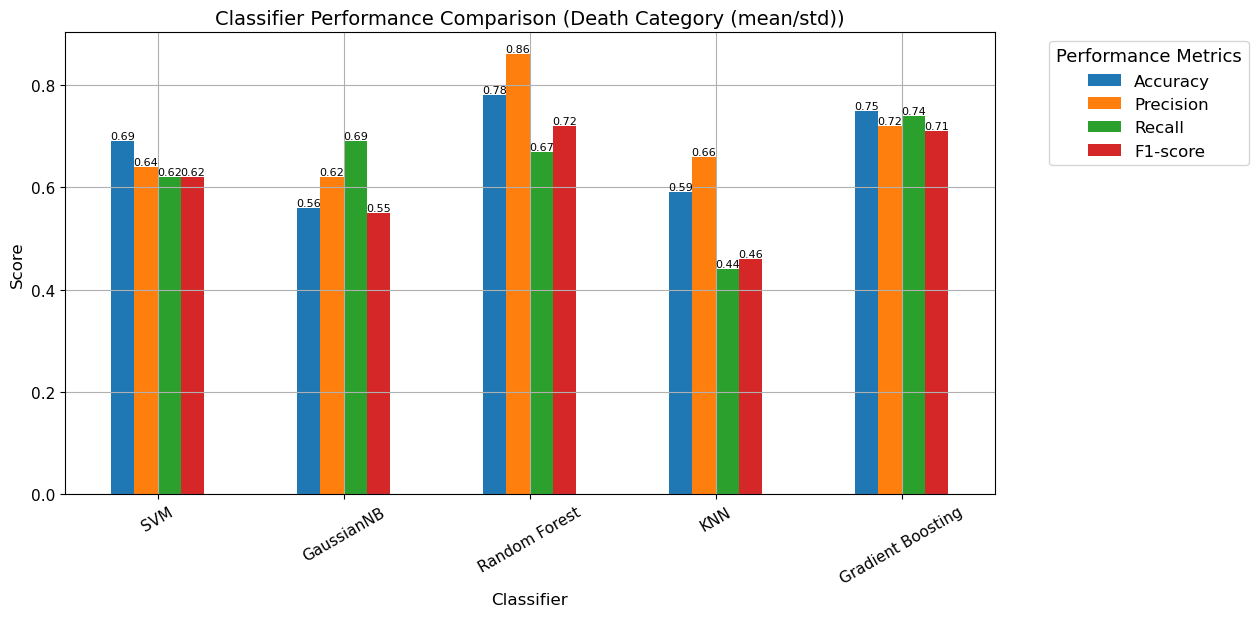

In [143]:
MeanStd_results = evaluate_classifiers(filtered_df2, "Death Category (mean/std)", n_neighbors=15)

#### Hyperparameters Tuning

In [144]:
def tune_classifiers(df, y_var):
    # Encode target variable
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:-5], LabelEncoder().fit_transform(df[y_var]),
                                                        test_size=0.2, stratify=df[y_var], random_state=0)

    classifiers = {
        "SVM": (SVC(probability=True), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]}),
        "Random Forest": (RandomForestClassifier(), 
                          {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 
                           'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10]}),
        "Gradient Boosting": (GradientBoostingClassifier(),
                              {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1], #fewer boosting stage => prevent overfitting
                               'max_depth': [2, 4], 'min_samples_split': [5, 10],
                               'subsample': [0.6, 0.8, 1.0],
                               'max_features': ['sqrt', 0.5]})
    }

    best_models = {}

    # Hyperparameter tuning for each classifier
    for name, (clf, param_grid) in classifiers.items():
        print(f"Tuning hyper-parameters for {name}")
        grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best {name} Parameters: {grid_search.best_params_}\n")

    # Evaluate tuned classifiers on the test set
    results = []
    for name, tuned_clf in best_models.items():
        y_pred = tuned_clf.predict(X_test)
        acc = round(accuracy_score(y_test, y_pred), 2)
        prec = round(precision_score(y_test, y_pred, average='macro', zero_division=0), 2)
        recl = round(recall_score(y_test, y_pred, average='macro', zero_division=0), 2)
        f1 = round(f1_score(y_test, y_pred, average='macro', zero_division=0), 2)

        results.append([name, acc, prec, recl, f1])
        print(f"Detailed classification report for {name}:\n")
        print(classification_report(y_test, y_pred))

    # Store results in a DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualize performance
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.6}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.79      0.92      0.85        24
           2       0.00      0.00      0.00         7

    accuracy                           0.72        32
   macro avg       0.37      0.64      0.45        32
weighted avg       0.60      0.72      0.65        32

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0     

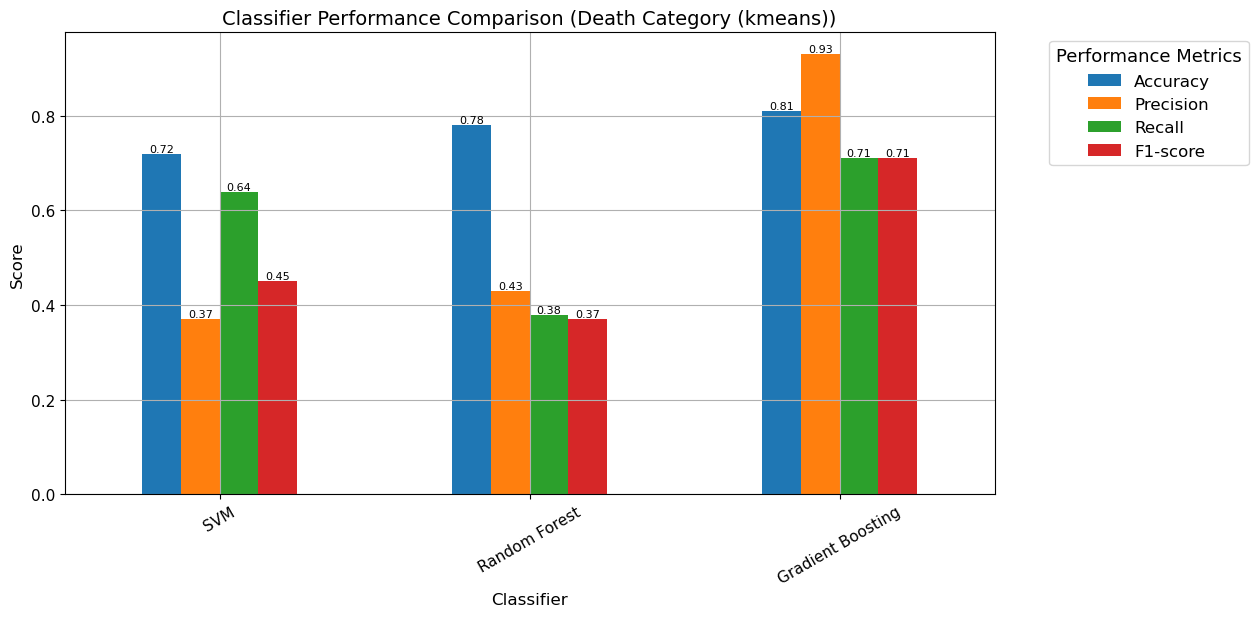

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.72,0.37,0.64,0.45
Random Forest,0.78,0.43,0.38,0.37
Gradient Boosting,0.81,0.93,0.71,0.71


In [145]:
tune_classifiers(filtered_df2, "Death Category (kmeans)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 0.8}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.93      1.00      0.97        28
           2       0.00      0.00      0.00         3

    accuracy                           0.91        32
   macro avg       0.48      0.67      0.54        32
weighted avg       0.83      0.91      0.87        32

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.00

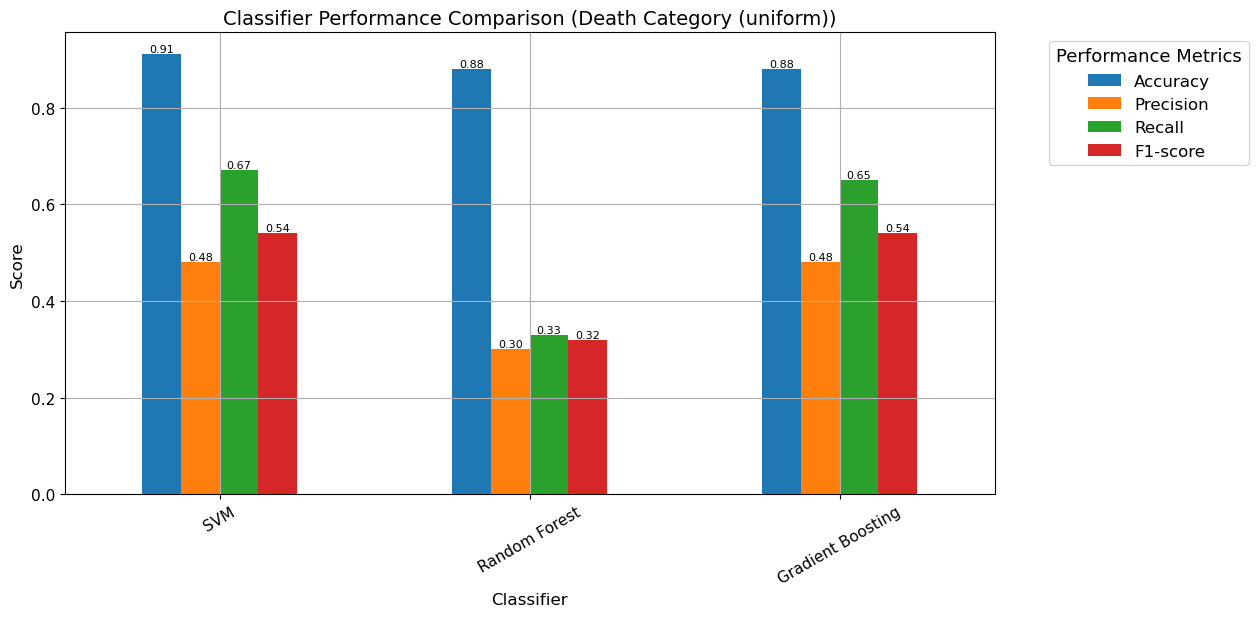

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.91,0.48,0.67,0.54
Random Forest,0.88,0.30,0.33,0.32
Gradient Boosting,0.88,0.48,0.65,0.54


In [146]:
tune_classifiers(filtered_df2, "Death Category (uniform)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.6}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.30      0.38      0.33         8
           2       0.33      0.25      0.29        12

    accuracy                           0.44        32
   macro avg       0.42      0.43      0.42        32
weighted avg       0.43      0.44      0.43        32

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       

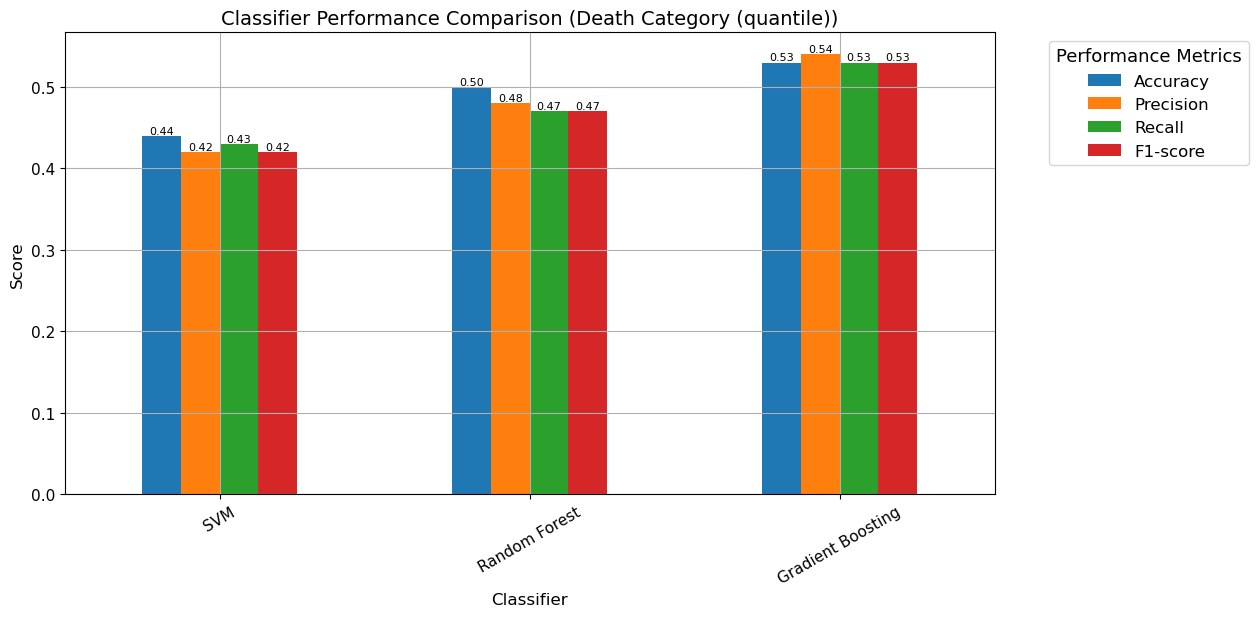

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.44,0.42,0.43,0.42
Random Forest,0.50,0.48,0.47,0.47
Gradient Boosting,0.53,0.54,0.53,0.53


In [147]:
tune_classifiers(filtered_df2, "Death Category (quantile)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.71      0.56      0.62         9
           2       0.71      0.79      0.75        19

    accuracy                           0.69        32
   macro avg       0.64      0.62      0.62        32
weighted avg       0.69      0.69      0.68        32

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.

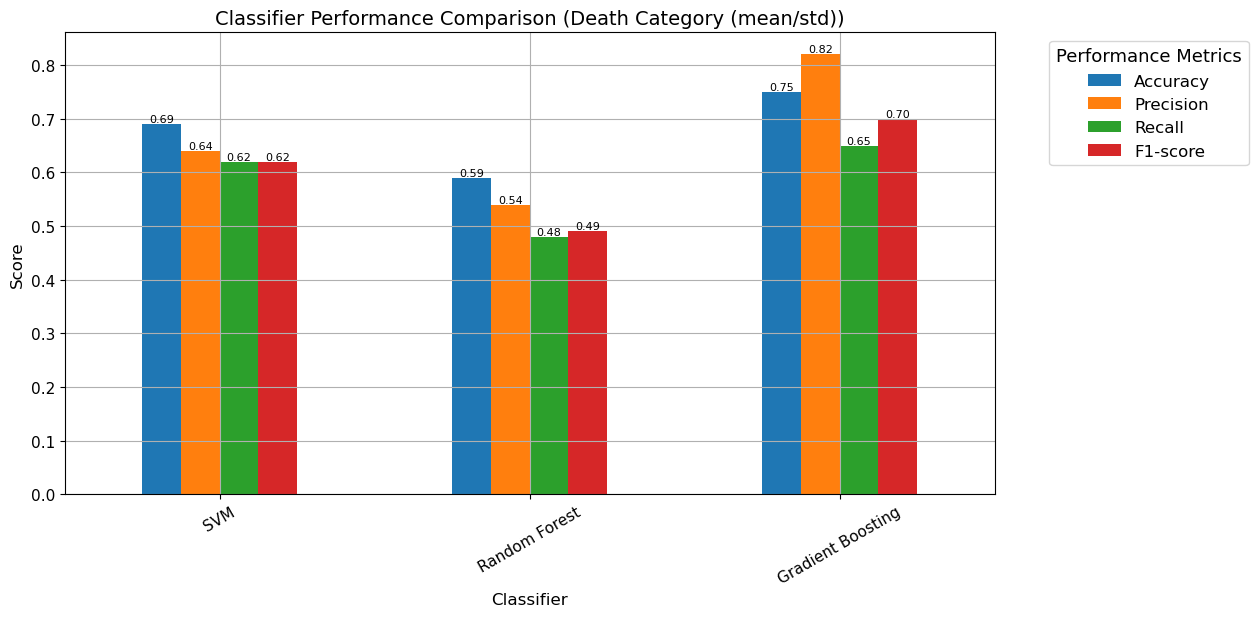

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.69,0.64,0.62,0.62
Random Forest,0.59,0.54,0.48,0.49
Gradient Boosting,0.75,0.82,0.65,0.70


In [148]:
tune_classifiers(filtered_df2, "Death Category (mean/std)")

### K-fold Cross-Validation

In [151]:
filtered_df3 = filtered_df.copy()

#### Determine optimal neighbors for each Death Category (KNN)

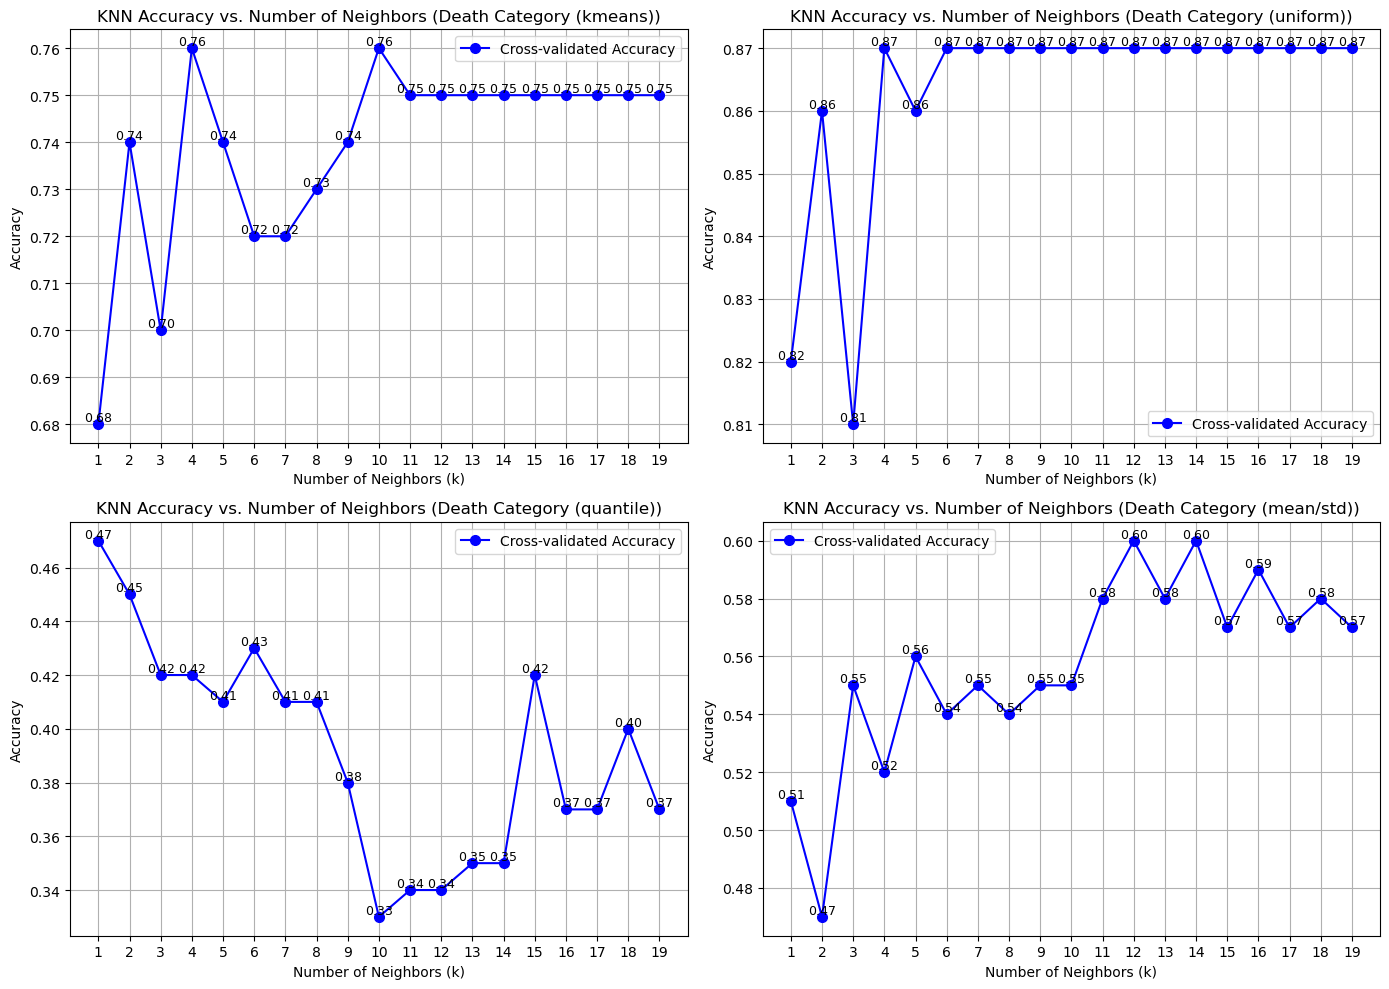

In [152]:
def determine_optimal_neighbors_kfold(filtered_df3, y_columns, k_range=list(range(1, 20))):    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, y_var in enumerate(y_columns):
        # Encode target variable
        y_encoded = LabelEncoder().fit_transform(filtered_df3[y_var])
        X = filtered_df3.iloc[:, 3:-5]
        
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  # 10-fold CV

        accuracy_scores = []

        for k in k_range:
            acc_scores = []

            for train_idx, test_idx in skf.split(X, y_encoded):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)

                acc_scores.append(accuracy_score(y_test, y_pred))

            # Average accuracy over 10 folds
            avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
            accuracy_scores.append((k, avg_acc))

        accuracy_scores_sorted = sorted(accuracy_scores, key=lambda x: x[0])

        # Extract sorted k-values and accuracy scores
        k_values_sorted = [score[0] for score in accuracy_scores_sorted]
        accuracies_sorted = [score[1] for score in accuracy_scores_sorted]

        # Plot
        ax = axes[idx]
        ax.plot(k_values_sorted, accuracies_sorted, marker='o', markersize=7, linestyle='-', color='b', label="Cross-validated Accuracy")

        # Display accuracy values
        for k, acc in zip(k_values_sorted, accuracies_sorted):
            ax.text(k, acc, f"{acc:.2f}", fontsize=9, ha="center", va="bottom", color="black")  # Label each point

        ax.set_xlabel("Number of Neighbors (k)")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"KNN Accuracy vs. Number of Neighbors ({y_var})")
        ax.set_xticks(k_values_sorted)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return dict(accuracy_scores)

death_categories = ["Death Category (kmeans)", "Death Category (uniform)", "Death Category (quantile)", "Death Category (mean/std)"]
kfold_k_dict = determine_optimal_neighbors_kfold(filtered_df3, death_categories)

In [153]:
def compute_knn_metrics_kfold(filtered_df3, y_var, k_list):
    y_encoded = LabelEncoder().fit_transform(filtered_df3[y_var])
    X = filtered_df3.iloc[:, 3:-5]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  # 10-fold CV
    results = []

    for k in k_list:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y_encoded):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # Compute average metrics over 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([k, avg_acc, avg_prec, avg_rec, avg_f1])

    return pd.DataFrame(results, columns=["K", "Accuracy", "Precision", "Recall", "F1-score"])

In [154]:
# Calculate for Death Category (quantile)
k_values_quantile_kfold = [4, 10]
quantile_category_kfold = "Death Category (kmeans)"

quantile_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, quantile_category_kfold, k_values_quantile_kfold)
print("\nMetrics for Quantile:")
display(quantile_metrics_kfold)


Metrics for Quantile:


,K,Accuracy,Precision,Recall,F1-score
0,4,0.76,0.45,0.49,0.45
1,10,0.76,0.32,0.42,0.36


In [156]:
# Calculate for Death Category (uniform)
k_values_uniform_kfold = [4] + list(range(6, 20))

uniform_category_kfold = "Death Category (uniform)"

uniform_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, uniform_category_kfold, k_values_uniform_kfold)
print("\nMetrics for Uniform:")
display(uniform_metrics_kfold)


Metrics for Uniform:


,K,Accuracy,Precision,Recall,F1-score
0,4,0.87,0.35,0.40,0.37
1,6,0.87,0.39,0.45,0.42
2,7,0.87,0.39,0.45,0.42
3,8,0.87,0.39,0.45,0.42
4,9,0.87,0.39,0.45,0.42
5,10,0.87,0.39,0.45,0.42
6,11,0.87,0.39,0.45,0.42
7,12,0.87,0.39,0.45,0.42
8,13,0.87,0.39,0.45,0.42
9,14,0.87,0.39,0.45,0.42


In [160]:
# Calculate for Death Category (mean/std)
k_values_meanstd_kfold = [12, 14]
meanstd_category_kfold = "Death Category (mean/std)"

meanstd_metrics_kfold = compute_knn_metrics_kfold(filtered_df3, meanstd_category_kfold, k_values_meanstd_kfold)
print("\nMetrics for Mean/Std:")
display(meanstd_metrics_kfold)


Metrics for Mean/Std:


,K,Accuracy,Precision,Recall,F1-score
0,12,0.6,0.39,0.38,0.36
1,14,0.6,0.34,0.36,0.32


In [177]:
# Summarize the findings:
# Define the final results
data_kfold = {
    "Death Category": ["Kmeans", "Uniform", "Quantile", "Mean/Std"],
    "K": [4, 8, 6, 12],
}

neighbor_results_kfold = pd.DataFrame(data_kfold)
print(neighbor_results_kfold)

  Death Category   K
0         Kmeans   4
1        Uniform   8
2       Quantile   6
3       Mean/Std  12


#### Perform Model evaluation

In [187]:
def evaluate_classifier_kfold(df, y_var, n_neighbors=7):
    # Encode target variable
    y_encoded = LabelEncoder().fit_transform(df[y_var])
    X = df.iloc[:, 3:-5]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  # 10-fold CV
    classifiers = [
        ("SVM", SVC(kernel="linear", probability=True)),
        ("GaussianNB", GaussianNB()),
        ("Random Forest", RandomForestClassifier()),
        ("KNN", KNeighborsClassifier(n_neighbors=n_neighbors)), 
        ("Gradient Boosting", GradientBoostingClassifier())
    ]

    results = []

    # Train and evaluate classifiers using 10-fold CV
    for name, clf in classifiers:
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y_encoded):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_hat))
            prec_scores.append(precision_score(y_test, y_hat, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_hat, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_hat, average='macro', zero_division=0))

        # Compute average metrics across 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])

    # Convert results to DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

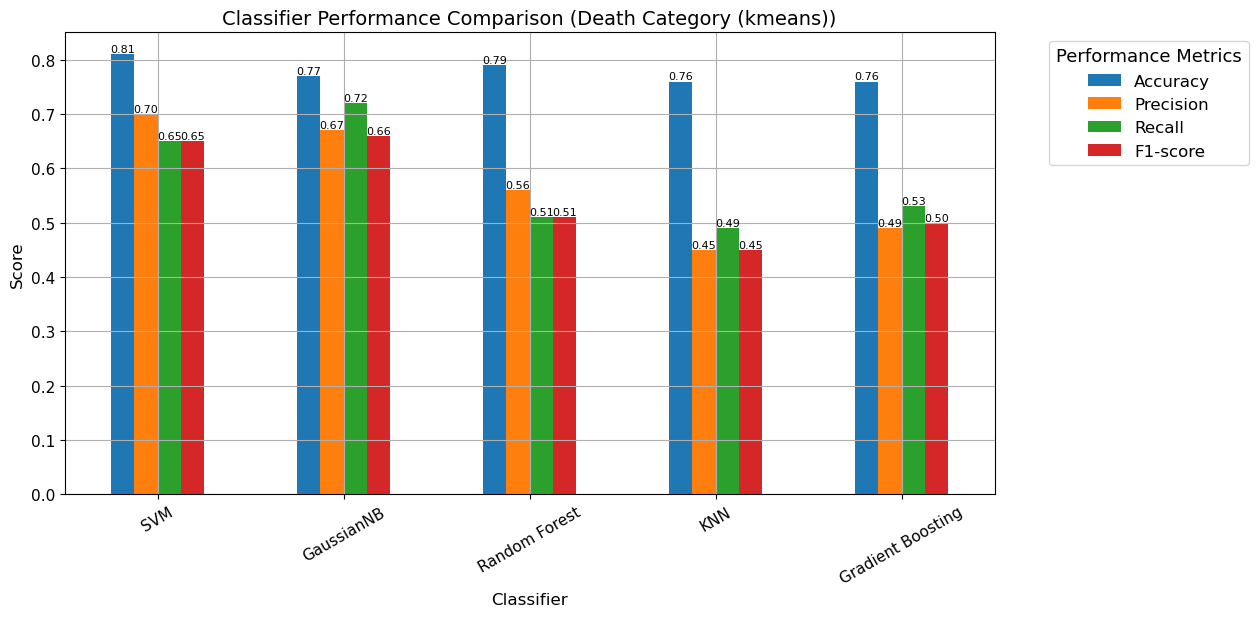

In [188]:
Kmeans_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (kmeans)", n_neighbors=4)

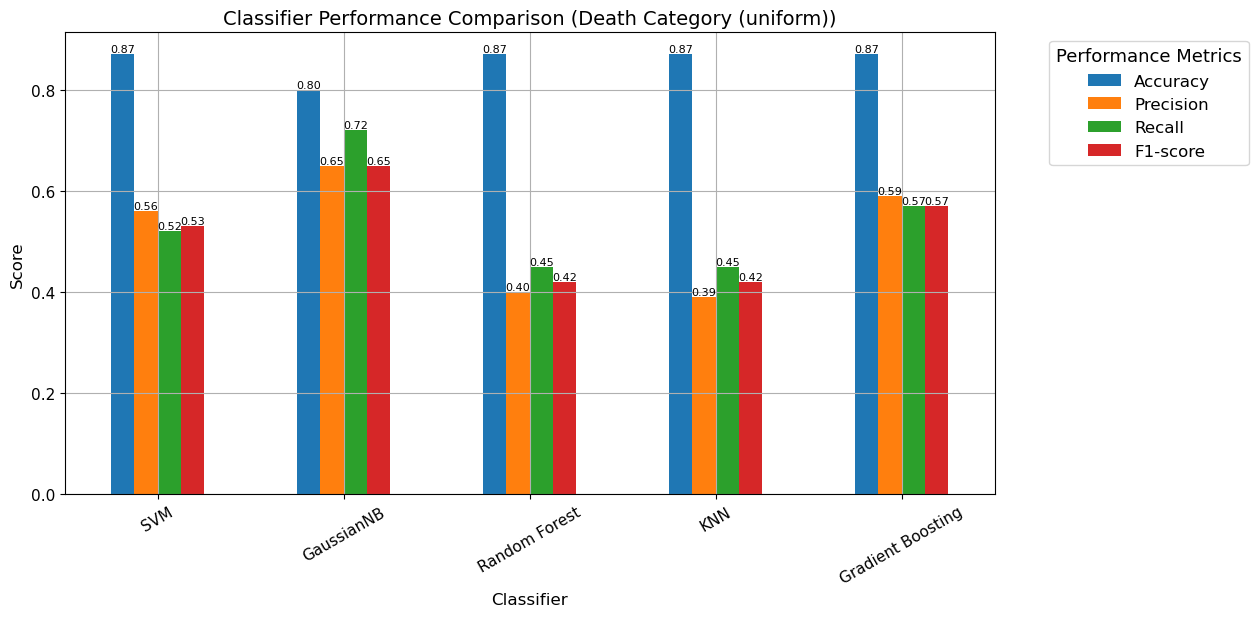

In [176]:
uniform_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (uniform)", n_neighbors=8)

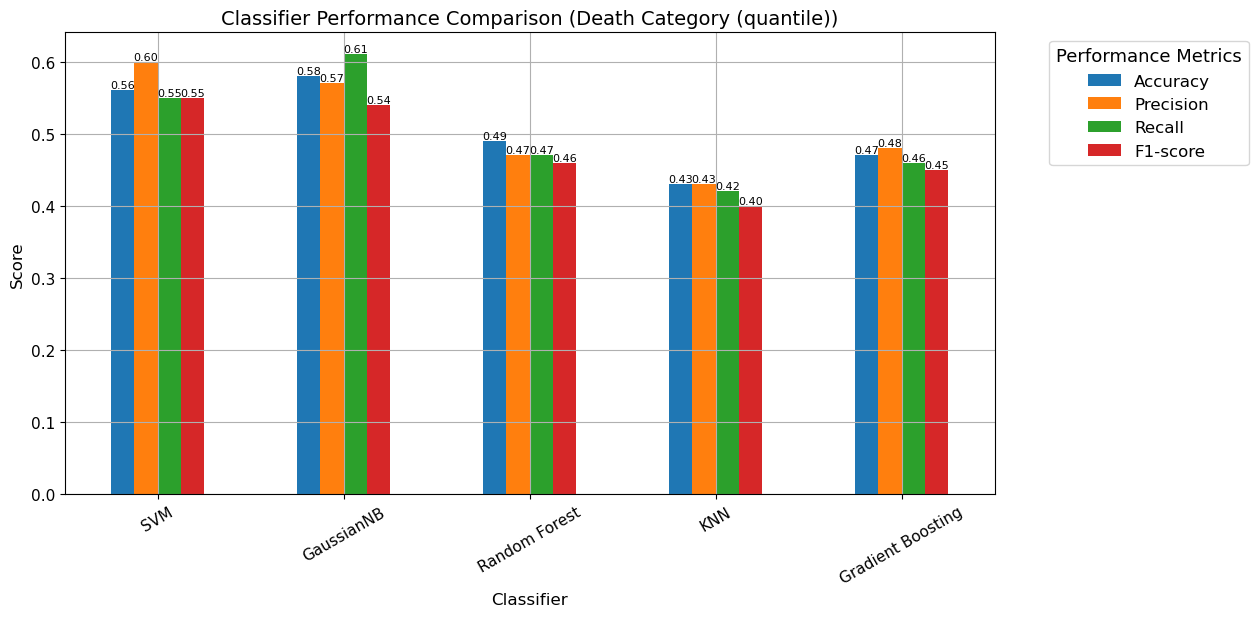

In [164]:
quantile_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (quantile)", n_neighbors=6)

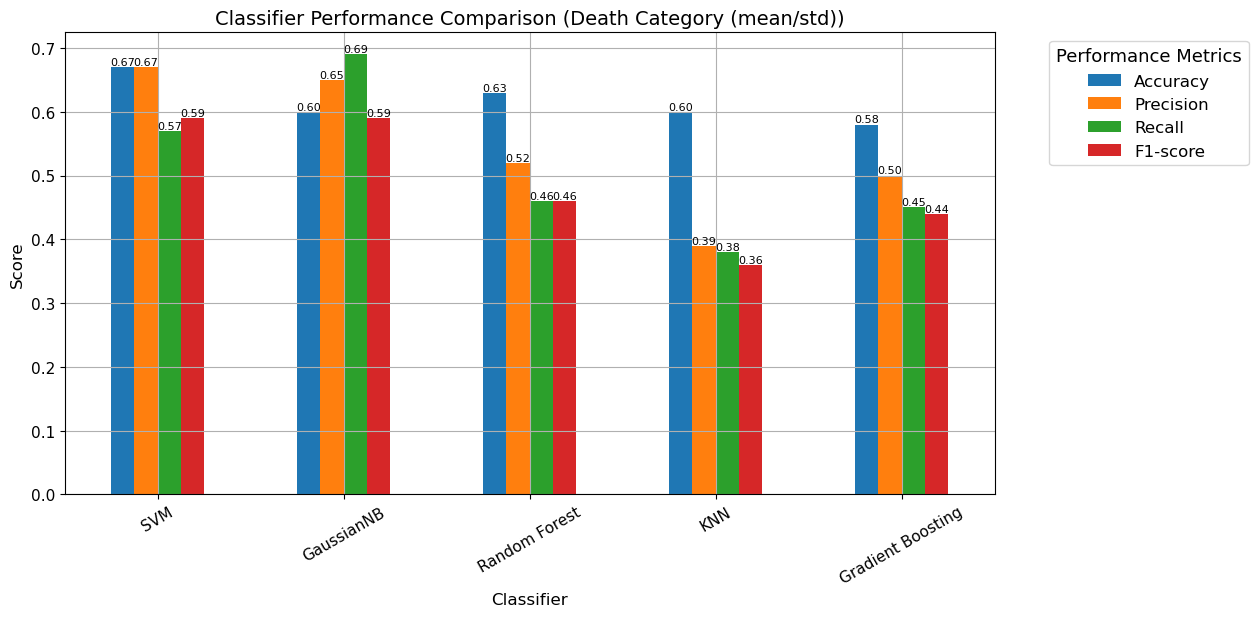

In [165]:
meanstd_results_kfold = evaluate_classifier_kfold(filtered_df3, "Death Category (mean/std)", n_neighbors=12)

#### Hyperparameters Tuning

In [178]:
def tune_classifier_kfold(df, y_var):
    # Encode target variable
    y_encoded = LabelEncoder().fit_transform(df[y_var])
    X = df.iloc[:, 3:-5]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0) 

    classifiers = {
        "SVM": (SVC(probability=True), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]}),
        "Random Forest": (RandomForestClassifier(),
                          {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10],
                           'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10]}),
        "Gradient Boosting": (GradientBoostingClassifier(),
                              {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1], 
                               'max_depth': [2, 4], 'min_samples_split': [5, 10],
                               'subsample': [0.6, 0.8, 1.0], 'max_features': ['sqrt', 0.5]})
    }

    best_models = {}

    # Hyperparameter tuning for each classifier using 10-fold CV
    for name, (clf, param_grid) in classifiers.items():
        print(f"Tuning hyper-parameters for {name}")
        grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=skf, n_jobs=-1)
        grid_search.fit(X, y_encoded)
        best_models[name] = grid_search.best_estimator_
        print(f"Best {name} Parameters: {grid_search.best_params_}\n")

    # Evaluate tuned classifiers using 10-fold CV
    results = []
    for name, tuned_clf in best_models.items():
        acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

        for train_idx, test_idx in skf.split(X, y_encoded):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

            tuned_clf.fit(X_train, y_train)
            y_pred = tuned_clf.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # Compute average metrics over 10 folds
        avg_acc = round(sum(acc_scores) / len(acc_scores), 2)
        avg_prec = round(sum(prec_scores) / len(prec_scores), 2)
        avg_rec = round(sum(rec_scores) / len(rec_scores), 2)
        avg_f1 = round(sum(f1_scores) / len(f1_scores), 2)

        results.append([name, avg_acc, avg_prec, avg_rec, avg_f1])
        print(f"Detailed classification report for {name}:\n")
        print(classification_report(y_test, y_pred))

    # Store results in a DataFrame
    df_results = pd.DataFrame(results, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"])
    df_results.set_index("Classifier", inplace=True)

    # Visualize performance
    fig, ax = plt.subplots(figsize=(12, 6))
    df_results.plot(kind="bar", ax=ax, rot=30, grid=True)

    ax.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc="upper left")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=8, label_type="edge")

    ax.set_title(f"Classifier Performance Comparison ({y_var})", fontsize=14)
    ax.set_xlabel("Classifier", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

    return df_results

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.79      1.00      0.88        11
           2       0.00      0.00      0.00         3

    accuracy                           0.73        15
   macro avg       0.26      0.33      0.29        15
weighted avg       0.58      0.73      0.65        15

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.00

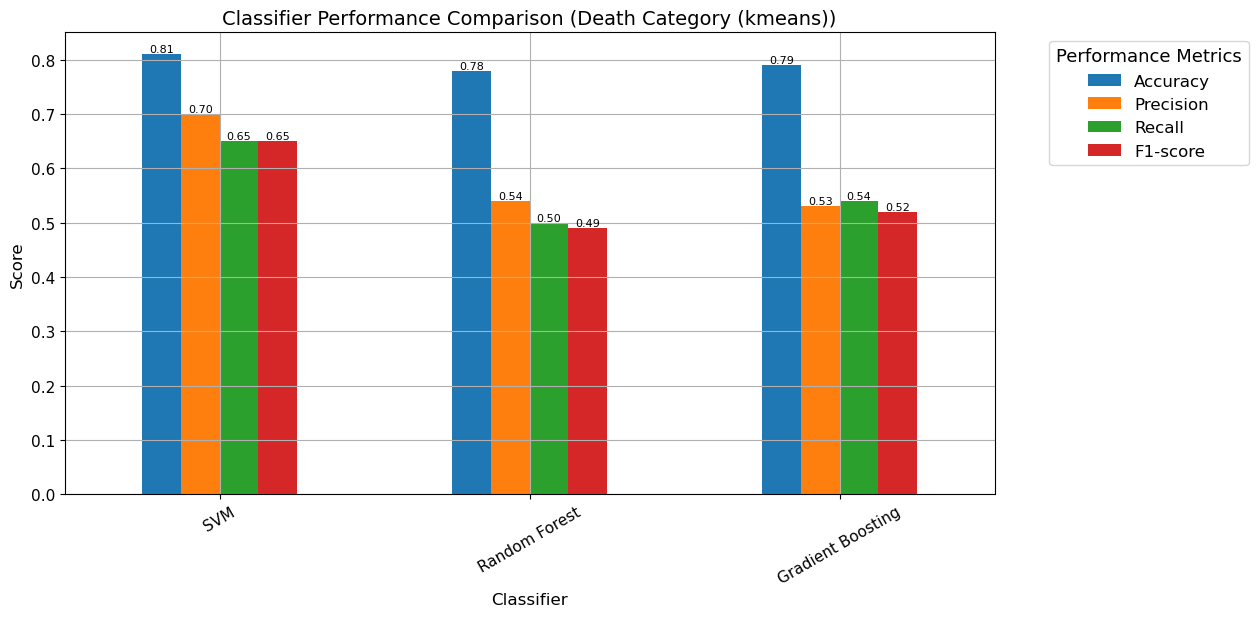

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.81,0.70,0.65,0.65
Random Forest,0.78,0.54,0.50,0.49
Gradient Boosting,0.79,0.53,0.54,0.52


In [179]:
tune_classifier_kfold(filtered_df3, "Death Category (kmeans)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.6}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       0.00      0.00      0.00         2

    accuracy                           0.87        15
   macro avg       0.43      0.50      0.46        15
weighted avg       0.75      0.87      0.80        15

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       

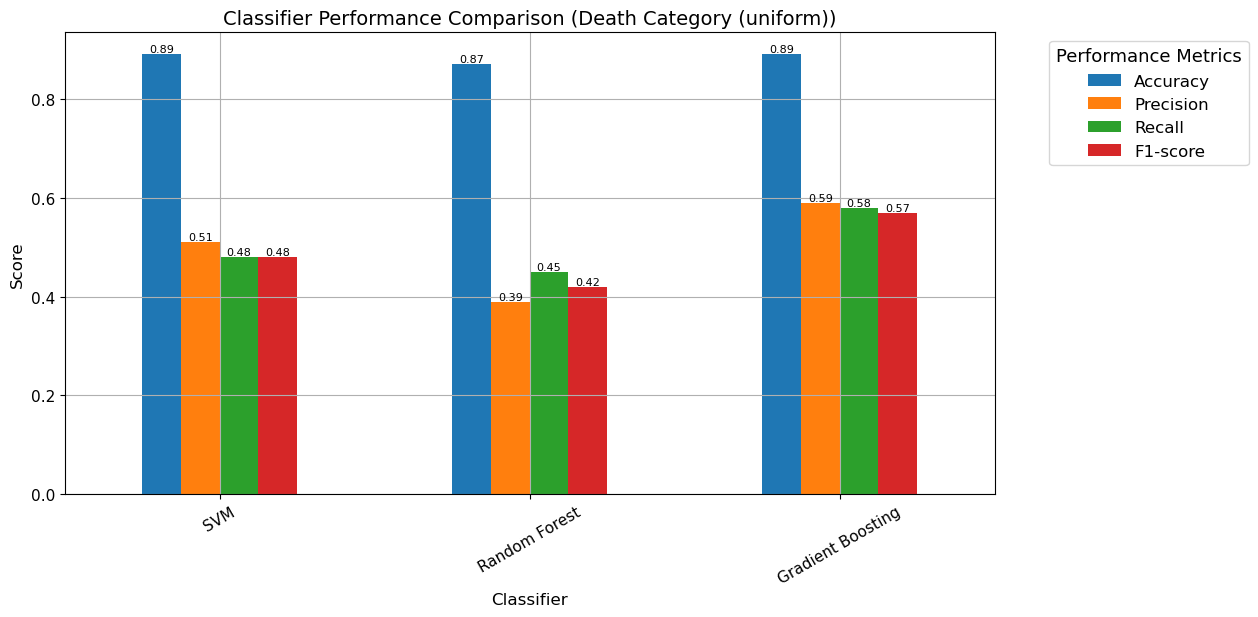

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.89,0.51,0.48,0.48
Random Forest,0.87,0.39,0.45,0.42
Gradient Boosting,0.89,0.59,0.58,0.57


In [180]:
tune_classifier_kfold(filtered_df3, "Death Category (uniform)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.6}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.25      0.40         4
           2       0.60      1.00      0.75         6

    accuracy                           0.67        15
   macro avg       0.78      0.62      0.61        15
weighted avg       0.76      0.67      0.63        15

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.3

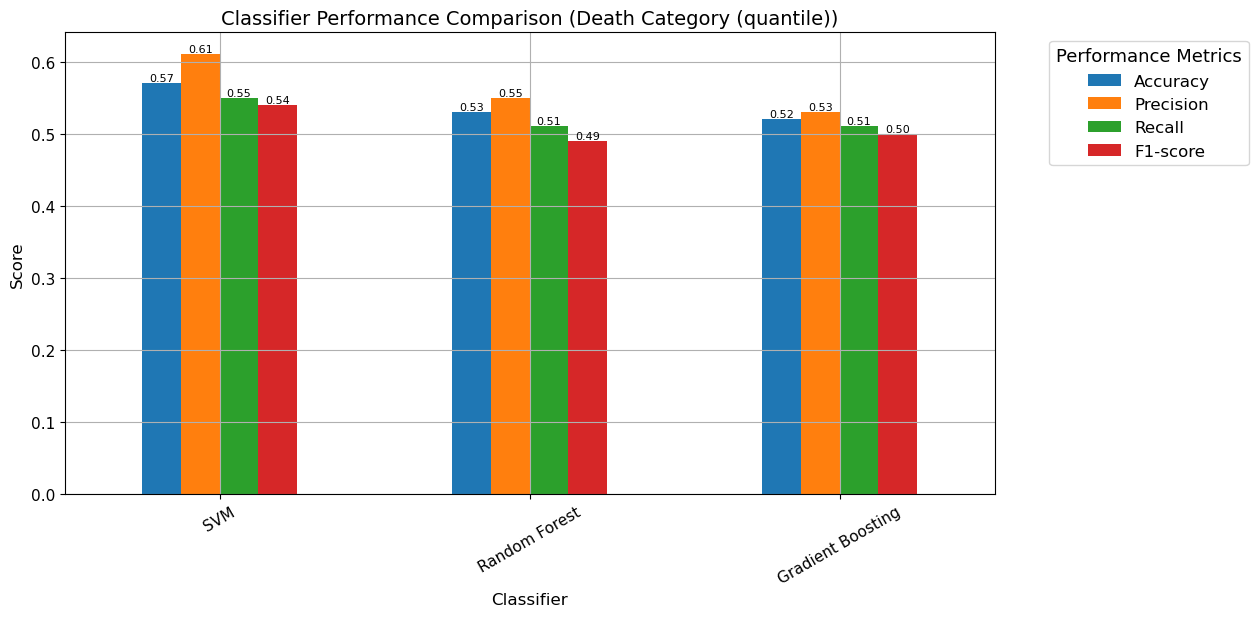

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.57,0.61,0.55,0.54
Random Forest,0.53,0.55,0.51,0.49
Gradient Boosting,0.52,0.53,0.51,0.50


In [181]:
tune_classifier_kfold(filtered_df3, "Death Category (quantile)")

Tuning hyper-parameters for SVM
Best SVM Parameters: {'C': 1, 'kernel': 'linear'}

Tuning hyper-parameters for Random Forest
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}

Tuning hyper-parameters for Gradient Boosting
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.5, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}

Detailed classification report for SVM:

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      0.25      0.33         4
           2       0.70      0.78      0.74         9

    accuracy                           0.67        15
   macro avg       0.62      0.68      0.62        15
weighted avg       0.64      0.67      0.64        15

Detailed classification report for Random Forest:

              precision    recall  f1-score   support

           0       1.0

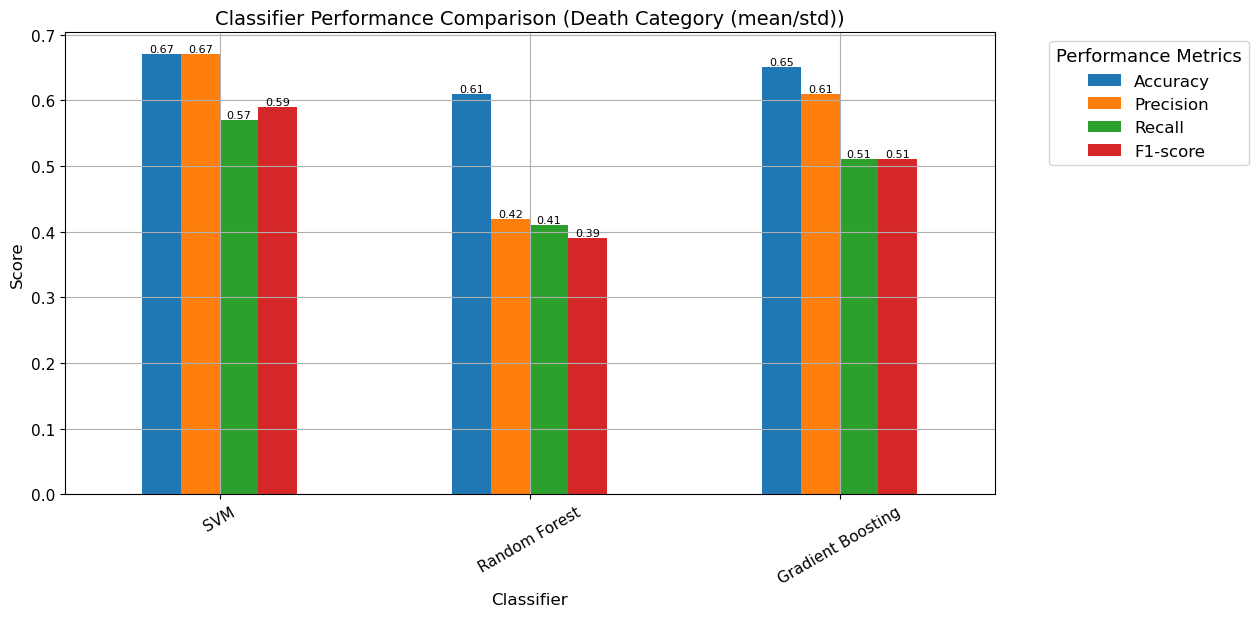

,Accuracy,Precision,Recall,F1-score
Classifier,,,,
SVM,0.67,0.67,0.57,0.59
Random Forest,0.61,0.42,0.41,0.39
Gradient Boosting,0.65,0.61,0.51,0.51


In [183]:
tune_classifier_kfold(filtered_df3, "Death Category (mean/std)")

BEST MODEL: between train_test_split and kfold: SVM 

1/ Death Category (kmeans)

2/ 10-fold Cross validation

3/ Because there is no difference after tuning, we'll choose the default model parameters.

We will only apply further analysis based on this SVM Model.

### Analysis on the Final Model

#### Visualize and report SVM (Kmeans, tuned, 10-fold) evaluation metrics

In [184]:
def evaluate_svm_kfold(df, y_var):
    # Apply LabelEncoder
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(df[y_var])
    X = df.iloc[:, 3:-5]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Define class labels dynamically
    class_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
    print("\nClass Labels:")
    for key, value in class_mapping.items():
        print(f"{key}: {value}")

    # Initialize SVM
    svm = SVC(C=1, kernel="linear", probability=True)

    # Storage for overall classification report components
    all_y_true = []
    all_y_pred = []

    # 10-Fold CV training & evaluation
    for train_idx, test_idx in skf.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        svm.fit(X_train, y_train)
        y_hat = svm.predict(X_test)

        # Collect predictions for full classification report
        all_y_true.extend(y_test)
        all_y_pred.extend(y_hat)

    # 🔹 Generate classification report
    report = classification_report(all_y_true, all_y_pred, target_names=encoder.classes_, zero_division=0, output_dict=True)

    # Extract per-class Accuracy separately
    class_accuracies = {label: accuracy_score(np.array(all_y_true) == idx, np.array(all_y_pred) == idx) for idx, label in enumerate(encoder.classes_)}

    # Convert classification report to DataFrame
    df_results = pd.DataFrame(report).transpose().round(2)

    # Add per-class Accuracy to the dataframe
    for idx, label in enumerate(encoder.classes_):
        df_results.at[label, "accuracy"] = round(class_accuracies[label], 2)

    print("\nStructured Classification Report:\n")
    print(df_results)

    # 🔹 Visualization: Grouped Bar Chart (Excluding Overall Accuracy)
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ["accuracy", "precision", "recall", "f1-score"]  # Shows class-wise Accuracy
    bar_width = 0.2
    x_positions = np.arange(len(df_results) - 3)  # Exclude overall averages from visualization

    for i, metric in enumerate(metrics):
        values = df_results.iloc[:-3][metric]  # Exclude Macro and Weighted Avg
        ax.bar(x_positions + i * bar_width, values, bar_width, label=metric)

        for j, value in enumerate(values):
            ax.text(x_positions[j] + i * bar_width, value + 0.02, f"{value:.2f}", ha="center", va="bottom", fontsize=10, color="black")

    ax.set_xticks(x_positions + bar_width)  
    ax.set_xticklabels(df_results.index[:-3], fontsize=11)  # Labels set dynamically
    ax.set_title(f"Per-Class Metrics (SVM - {y_var})", fontsize=14)
    ax.set_xlabel("Class Labels")
    ax.set_ylabel("Score")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)

    plt.show()


Class Labels:
0: High
1: Low
2: Medium

Structured Classification Report:

              precision  recall  f1-score  support  accuracy
High               0.60    0.86      0.71     7.00      0.97
Low                0.85    0.92      0.89   117.00      0.82
Medium             0.63    0.38      0.47    32.00      0.83
accuracy           0.81    0.81      0.81     0.81       NaN
macro avg          0.69    0.72      0.69   156.00       NaN
weighted avg       0.79    0.81      0.79   156.00       NaN


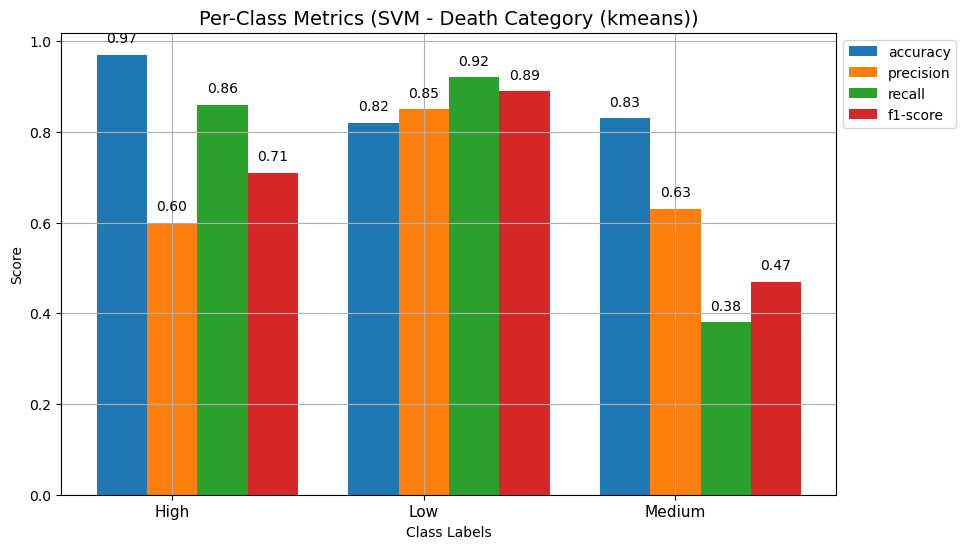

In [189]:
evaluate_svm_kfold(filtered_df3, "Death Category (kmeans)")

#### Visualize the AUC-ROC curve

In [190]:
def auc_roc_curve(df, y_var):

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(df[y_var])
    X = df.iloc[:, 3:-5]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(C=1, kernel="linear", probability=True)

    # Binarize labels for multi-class ROC analysis
    y_binarized = label_binarize(y_encoded, classes=np.unique(y_encoded))
    n_classes = y_binarized.shape[1]

    fpr = {i: [] for i in range(n_classes)}
    tpr = {i: [] for i in range(n_classes)}
    roc_auc = {}

    for train_idx, test_idx in skf.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        svm.fit(X_train, y_train)
        y_prob = svm.predict_proba(X_test)

        # Compute ROC curve & AUC for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_binarized[test_idx, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

    # Visualization: AUC-ROC Curve
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ["blue", "orange", "green"]
    
    for i, label in enumerate(encoder.classes_):
        ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f"{label} (AUC = {roc_auc[i]:.2f})")
    
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
    ax.set_title("AUC-ROC Curve (SVM)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

    plt.show()

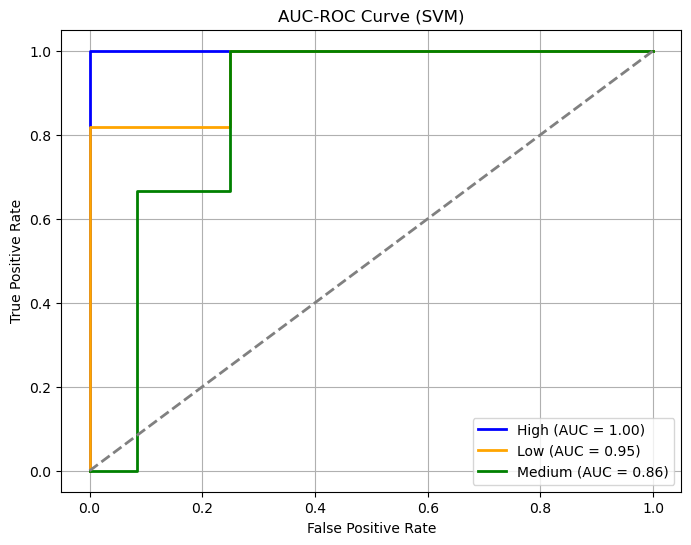

In [191]:
auc_roc_curve(filtered_df3, "Death Category (kmeans)")

#### Feature weight for SVM (Top 15)


Top 28 Most Important Features (SVM):
 Absolute Weight                            Feature
        0.800631     Yolk sac infection/ omphalitis
        0.589758                    Marek's Disease
        0.520550                         South East
        0.450692                          Month_sin
        0.330089                       PCA_Weather5
        0.307131                       PCA_Weather4
        0.210070 Days of frost East of England_lag6
        0.198075                      West Midlands
        0.124524                           Red Mite
        0.094331                       PCA_Weather3
        0.078204        Eggs Export (Million Dozen)
        0.062242                              Wales
        0.057870                       PCA_Weather2
        0.020749                           Neoplasm
        0.017242 Eggs RPI average price (per dozen)
        0.008098        Eggs Import (Million Dozen)
        0.002565          Slaughter (Million birds)


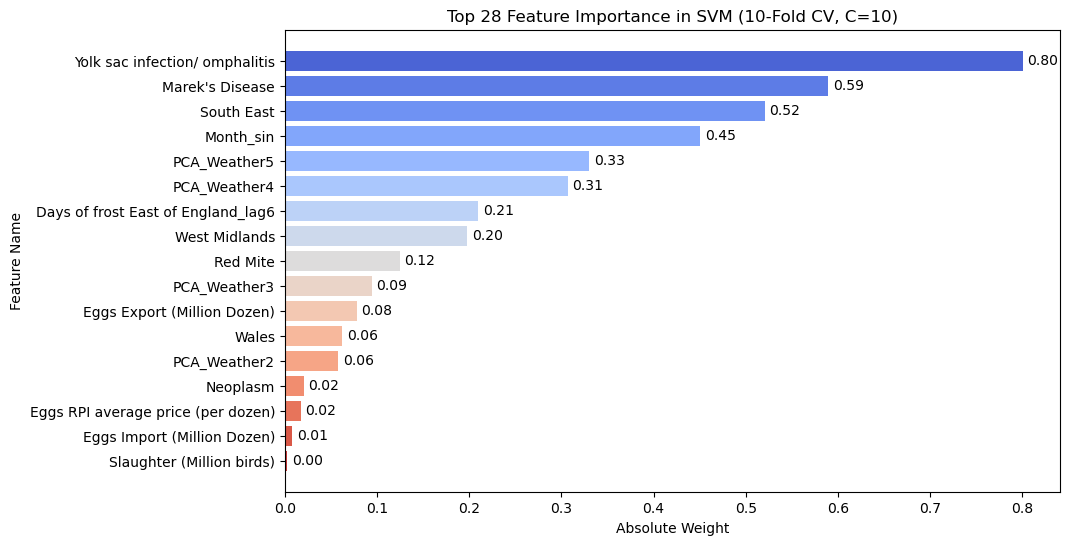

In [192]:
def svm_feature_importance(df, y_var, top_n=28):
    X = df.iloc[:, 3:-5]  
    y = df[y_var]

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(C=1, kernel="linear", probability=True)

    feature_weights = np.zeros(X.shape[1])  

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        svm.fit(X_train, y_train)
        feature_weights += svm.coef_[0]  # Aggregate weights

    # Normalize Weights Across Folds
    feature_weights /= skf.get_n_splits()

    # Extract & Sort Feature Importance
    f_names = X.columns.tolist()
    sorted_features = sorted(zip(abs(feature_weights), f_names), reverse=True)[:top_n]

    # Convert to DataFrame
    df_importance = pd.DataFrame(sorted_features, columns=["Absolute Weight", "Feature"])
    
    # Print Sorted Feature Importance
    print("\nTop {} Most Important Features (SVM):".format(top_n))
    print(df_importance.to_string(index=False))

    # Visualization:
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("coolwarm", len(df_importance))  # Dynamic color mapping
    
    bars = plt.barh(df_importance["Feature"], df_importance["Absolute Weight"], color=colors)
    
    # Add labels next to each bar
    for bar, weight in zip(bars, df_importance["Absolute Weight"]):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{weight:.2f}", va="center", fontsize=10, color="black")
    
    plt.xlabel("Absolute Weight")
    plt.ylabel("Feature Name")
    plt.title("Top {} Feature Importance in SVM (10-Fold CV, C=10)".format(top_n))
    plt.gca().invert_yaxis() 
    plt.show()

df_importance = svm_feature_importance(filtered_df3, "Death Category (kmeans)")

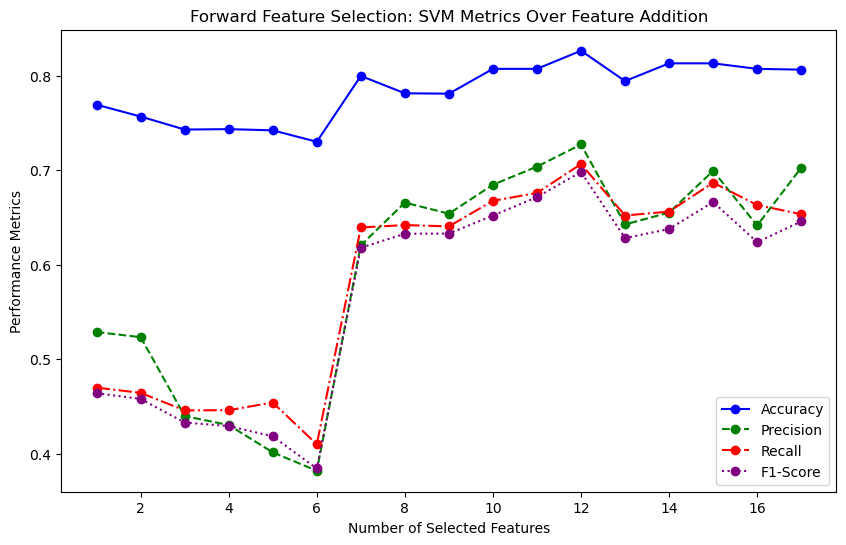

In [209]:
def forward_feature_selection_svm(df, y_var, sorted_features):
    y = df[y_var]
    selected_features = []
    selection_steps = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(C=1, kernel="linear", probability=True)

    for feature in sorted_features: 
        selected_features.append(feature)
        X = df[selected_features]  

        accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)

            accuracy_list.append(accuracy_score(y_test, y_pred))
            precision_list.append(precision_score(y_test, y_pred, average="macro"))
            recall_list.append(recall_score(y_test, y_pred, average="macro"))
            f1_list.append(f1_score(y_test, y_pred, average="macro"))

        # Store performance metrics for the step
        selection_steps.append({
            "Feature Count": len(selected_features),
            "Added Feature": feature,
            "Accuracy": np.mean(accuracy_list),
            "Precision": np.mean(precision_list),
            "Recall": np.mean(recall_list),
            "F1-Score": np.mean(f1_list)
        })

    # Convert results into a DataFrame for visualization
    df_selection = pd.DataFrame(selection_steps)

    # Plot accuracy trend as features are added
    plt.figure(figsize=(10, 6))
    plt.plot(df_selection["Feature Count"], df_selection["Accuracy"], marker="o", linestyle="-", color="blue", label="Accuracy")
    plt.plot(df_selection["Feature Count"], df_selection["Precision"], marker="o", linestyle="--", color="green", label="Precision")
    plt.plot(df_selection["Feature Count"], df_selection["Recall"], marker="o", linestyle="-.", color="red", label="Recall")
    plt.plot(df_selection["Feature Count"], df_selection["F1-Score"], marker="o", linestyle=":", color="purple", label="F1-Score")

    plt.xlabel("Number of Selected Features")
    plt.ylabel("Performance Metrics")
    plt.title("Forward Feature Selection: SVM Metrics Over Feature Addition")
    plt.legend()
    plt.show()

    return df_selection

# Extract sorted feature names from SVM importance results (Most important first)
sorted_feature_names_svm = df_importance.sort_values("Absolute Weight", ascending=False)["Feature"].tolist()

df_selection_svm = forward_feature_selection_svm(filtered_df3, "Death Category (kmeans)", sorted_feature_names_svm)

In [215]:
def get_top_features(df_importance, top_n=12):

    top_features = df_importance.sort_values("Absolute Weight", ascending=False).head(top_n)
    top_feature_list = top_features["Feature"].tolist()

    print("\nTop {} Most Important Features (SVM):".format(top_n))
    print(top_feature_list)

    return top_feature_list

top_12_features = get_top_features(df_importance, top_n=12)


Top 12 Most Important Features (SVM):
['Yolk sac infection/ omphalitis', "Marek's Disease", 'South East', 'Month_sin', 'PCA_Weather5', 'PCA_Weather4', 'Days of frost East of England_lag6', 'West Midlands', 'Red Mite', 'PCA_Weather3', 'Eggs Export (Million Dozen)', 'Wales']


In [236]:
def svm_with_top_features_label_encoded(df, y_var, top_features):
    X = df[top_features].astype(float)  # Use only top 12 features
    
    # Apply Label Encoding to the target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[y_var])

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    svm = SVC(C=1, kernel="linear", probability=True)

    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]  # Use encoded labels

        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, average="macro"))
        recall_list.append(recall_score(y_test, y_pred, average="macro"))
        f1_list.append(f1_score(y_test, y_pred, average="macro"))

    # Compute average metrics across all folds
    metrics = {
        "Accuracy": np.mean(accuracy_list),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list),
        "F1-Score": np.mean(f1_list)
    }

    print("\nSVM Classifier Performance Using Top 12 Features (Label Encoded Target):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

# Run SVM classifier with label encoding applied
svm_metrics_encoded = svm_with_top_features_label_encoded(filtered_df3, "Death Category (kmeans)", top_12_features)


SVM Classifier Performance Using Top 12 Features (Label Encoded Target):
Accuracy: 0.8262
Precision: 0.7271
Recall: 0.7064
F1-Score: 0.6981


In [229]:

label_encoder = LabelEncoder()
filtered_df3["Encoded_Target"] = label_encoder.fit_transform(filtered_df3["Death Category (kmeans)"])

# Define features & target variable
X = filtered_df3[top_12_features].astype(float)
y = filtered_df3["Encoded_Target"]

# Set up stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Define SVM model & expanded hyperparameter grid
svm = SVC()

param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'shrinking': [True, False], 'class_weight': [None, 'balanced'], 'tol': [1e-3, 1e-4]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'max_iter': [-1, 1000, 5000]}
]

# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(
    svm, param_grid, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    refit="accuracy", cv=skf, n_jobs=-1, verbose=2
)
grid_search.fit(X, y)

# Get best hyperparameters & create best SVM model
best_params = grid_search.best_params_
best_svm = SVC(**best_params)

# Evaluate best SVM model with cross-validation
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)

    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average="macro"))
    recall_list.append(recall_score(y_test, y_pred, average="macro"))
    f1_list.append(f1_score(y_test, y_pred, average="macro"))

print("\nBest Hyperparameters:", best_params)
print("\nBest SVM Model Performance (10-Fold CV):")
print(f"Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f}")

Fitting 10 folds for each of 88 candidates, totalling 880 fits

Best Hyperparameters: {'C': 1, 'class_weight': None, 'kernel': 'linear', 'max_iter': 1000}

Best SVM Model Performance (10-Fold CV):
Accuracy: 0.8329
Precision: 0.7299
Recall: 0.7148
F1-Score: 0.7057


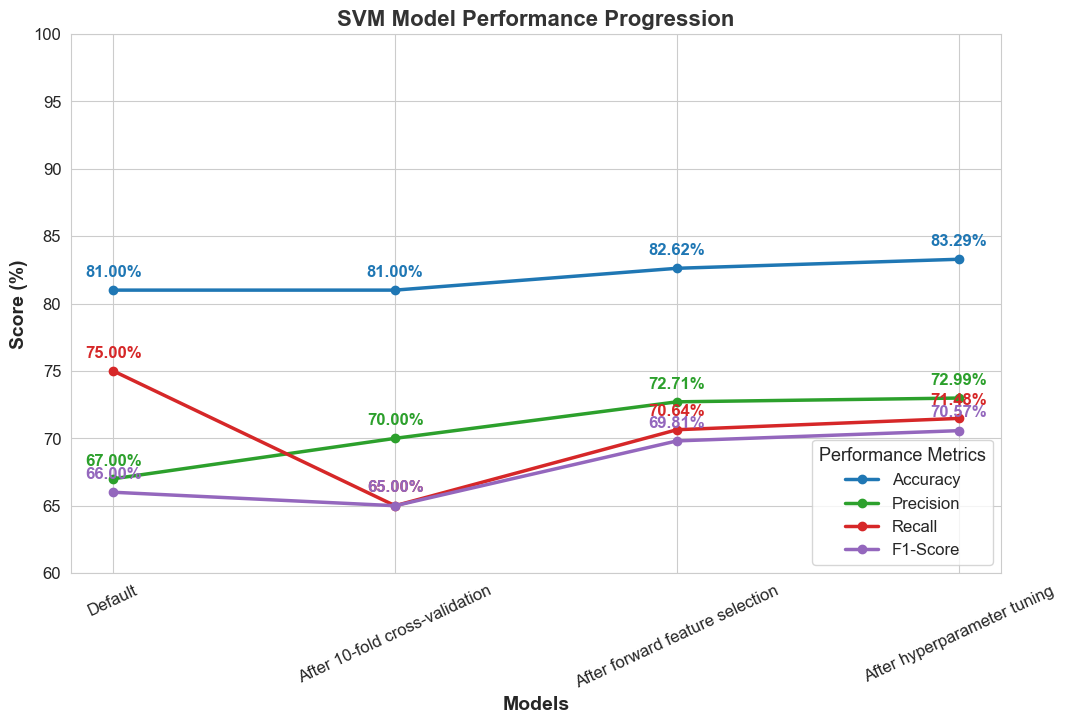

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_normal_metrics(names, accuracies, precisions, recalls, f1_scores):
    """Creates a clean line graph for SVM model performance across different evaluation metrics."""
    
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd"]  # Blue, Green, Red, Purple

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")

    x_positions = np.arange(len(names))  # Convert model names into numeric positions

    # Plot each metric separately using solid lines
    for metric, color, values in zip(metrics, colors, [accuracies, precisions, recalls, f1_scores]):
        plt.plot(x_positions, values, marker="o", linestyle="-", linewidth=2.5, color=color, label=metric)

        # Add data labels above each point
        for i, value in enumerate(values):
            plt.text(x_positions[i], value + 1, f"{value:.2f}%", fontsize=12, color=color, ha="center", fontweight="bold")

    # Formatting axes and labels
    plt.xticks(x_positions, names, fontsize=12, rotation=25)
    plt.xlabel("Models", fontsize=14, fontweight="bold")
    plt.ylabel("Score (%)", fontsize=14, fontweight="bold")
    plt.title("SVM Model Performance Progression", fontsize=16, fontweight="bold", color="#333333")
    plt.yticks(fontsize=12)
    plt.ylim(60, 100)  # Adjust score ranges as needed

    # Add a clear legend for metrics
    plt.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, loc="lower right", frameon=True)

    # Show the graph
    plt.show()

# Example usage
plot_normal_metrics(
    names=["Default", "After 10-fold cross-validation", "After forward feature selection", "After hyperparameter tuning"],
    accuracies=[81, 81, 82.62, 83.29],
    precisions=[67, 70, 72.71, 72.99],
    recalls=[75, 65, 70.64, 71.48],
    f1_scores=[66, 65, 69.81, 70.57]
)

In [259]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import numpy as np

def smote_svm_10fold(df, y_var, top_features, svm_params):
    """
    Applies SMOTE to balance the dataset and performs 10-fold cross-validation using an SVM model.

    Parameters:
    - df: DataFrame (dataset)
    - y_var: str (target variable column name)
    - top_features: list (selected top features for model training)
    - svm_params: dict (hyperparameters for SVM)

    Returns:
    - Prints evaluation metrics (Accuracy, Precision, Recall, F1-score)
    """

    # Define features & target variable
    X = df[top_features].astype(float)
    
    # Apply Label Encoding to the target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[y_var])

    # Set up stratified 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Lists to store evaluation metrics across folds
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    # Iterate over cross-validation folds
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE to balance the training data
        smote = SMOTE(sampling_strategy="auto", random_state=0)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Initialize & train SVM model with given parameters
        svm = SVC(**svm_params)
        svm.fit(X_train_smote, y_train_smote)

        # Make predictions
        y_pred = svm.predict(X_test)

        # Evaluate model performance
        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, average="macro"))
        recall_list.append(recall_score(y_test, y_pred, average="macro"))
        f1_list.append(f1_score(y_test, y_pred, average="macro"))

    # Compute average metrics across all folds
    metrics = {
        "Accuracy": np.mean(accuracy_list),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list),
        "F1-Score": np.mean(f1_list)
    }

    print("\nSVM Model Performance with SMOTE (10-Fold CV):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

# Example usage with filtered_df3
svm_hyperparams = {"C": 1, "kernel": "linear", "probability": True}
smote_metrics = smote_svm_10fold(filtered_df3, "Death Category (kmeans)", top_12_features, svm_hyperparams)


SVM Model Performance with SMOTE (10-Fold CV):
Accuracy: 0.7942
Precision: 0.7153
Recall: 0.7499
F1-Score: 0.7198


In [271]:
def balance_data_with_smote(df, response_var, feature_cols):
    """
    Applies Label Encoding and SMOTE to balance the dataset, then returns the balanced DataFrame.

    Parameters:
    - df: DataFrame (original dataset)
    - response_var: str (response variable column name, e.g., 'Death Category (kmeans)')
    - feature_cols: list (selected features for balancing)

    Returns:
    - balanced_df: DataFrame (balanced dataset after SMOTE, with label-encoded target)
    - label_encoder: LabelEncoder object for decoding target values later if needed
    """

    # Apply Label Encoding to the response variable
    label_encoder = LabelEncoder()
    df["Encoded_Target"] = label_encoder.fit_transform(df[response_var])

    # Define features and target variable
    X = df[feature_cols].astype(float)
    y = df["Encoded_Target"]

    # Apply SMOTE
    smote = SMOTE(sampling_strategy="auto", random_state=0)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Save balanced dataset to a new DataFrame
    balanced_df = pd.DataFrame(X_resampled, columns=feature_cols)
    balanced_df["Encoded_Target"] = y_resampled  # Store label-encoded target

    return balanced_df, label_encoder

# Example usage with filtered_df3
balanced_df, label_encoder = balance_data_with_smote(filtered_df3, "Death Category (kmeans)", top_12_features)

In [272]:
balanced_df.head()

,Yolk sac infection/ omphalitis,Marek's Disease,South East,Month_sin,PCA_Weather5,PCA_Weather4,Days of frost East of England_lag6,West Midlands,Red Mite,PCA_Weather3,Eggs Export (Million Dozen),Wales,Encoded_Target
0,0.0,1.0,1.0,0.500000,0.306910,0.590886,9.2,0.0,0.0,-1.363307,0.7,0.0,1
1,0.0,0.0,0.0,0.866025,-0.866313,1.506746,9.2,1.0,0.0,-1.072032,0.7,0.0,1
2,0.0,0.0,0.0,1.000000,-0.527678,-1.935279,9.2,0.0,0.0,0.206567,0.8,2.0,1
3,0.0,0.0,0.0,0.866025,0.047142,-0.624267,9.2,1.0,0.0,3.831355,0.7,0.0,2
4,0.0,0.0,0.0,0.500000,0.455468,-1.264003,9.2,2.0,0.0,1.029047,0.8,0.0,1


In [261]:
display(df_bin_counts)

,kmeans,uniform,quantile,mean/std
High,7,3,57,20
Low,117,136,42,42
Medium,32,17,57,94


In [275]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define features & target variable using balanced_df
X = balanced_df[top_12_features].astype(float)
y = balanced_df["Encoded_Target"]

# Set up stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Define SVM model & expanded hyperparameter grid
svm = SVC()

param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'shrinking': [True, False], 'class_weight': [None, 'balanced'], 'tol': [1e-3, 1e-4]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'max_iter': [-1, 1000, 5000]}
]

# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(
    svm, param_grid, scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    refit="accuracy", cv=skf, n_jobs=-1, verbose=2
)
grid_search.fit(X, y)

# Get best hyperparameters & create best SVM model
best_params = grid_search.best_params_
best_svm = SVC(**best_params)

# Evaluate best SVM model with cross-validation
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_svm.fit(X_train, y_train)
    y_pred = best_svm.predict(X_test)

    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average="macro"))
    recall_list.append(recall_score(y_test, y_pred, average="macro"))
    f1_list.append(f1_score(y_test, y_pred, average="macro"))

# Print final model performance metrics
print("\nBest Hyperparameters:", best_params)
print("\nBest SVM Model Performance (10-Fold CV on Balanced Data):")
print(f"Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f}")

Fitting 10 folds for each of 88 candidates, totalling 880 fits

Best Hyperparameters: {'C': 1000, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001}

Best SVM Model Performance (10-Fold CV on Balanced Data):
Accuracy: 0.9175
Precision: 0.9189
Recall: 0.9164
F1-Score: 0.9160


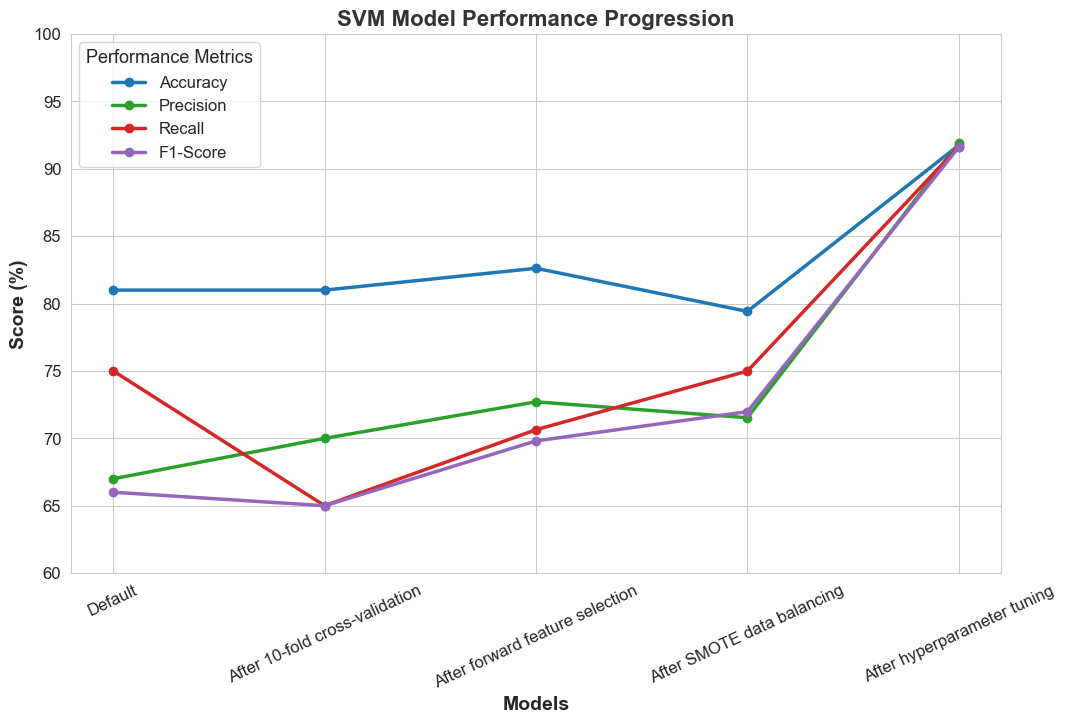

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_normal_metrics(names, accuracies, precisions, recalls, f1_scores):
    """Creates a clean line graph for SVM model performance across different evaluation metrics."""
    
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd"]  # Blue, Green, Red, Purple

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")

    x_positions = np.arange(len(names))  # Convert model names into numeric positions

    # Plot each metric separately using solid lines
    for metric, color, values in zip(metrics, colors, [accuracies, precisions, recalls, f1_scores]):
        plt.plot(x_positions, values, marker="o", linestyle="-", linewidth=2.5, color=color, label=metric)

    # Formatting axes and labels
    plt.xticks(x_positions, names, fontsize=12, rotation=25)
    plt.xlabel("Models", fontsize=14, fontweight="bold")
    plt.ylabel("Score (%)", fontsize=14, fontweight="bold")
    plt.title("SVM Model Performance Progression", fontsize=16, fontweight="bold", color="#333333")
    plt.yticks(fontsize=12)
    plt.ylim(60, 100)  # Adjust score ranges as needed

    # Add a clear legend for metrics
    plt.legend(title="Performance Metrics", fontsize=12, title_fontsize=13, loc="best", frameon=True)

    # Show the graph
    plt.show()

# Example usage
plot_normal_metrics(
    names=["Default", "After 10-fold cross-validation", "After forward feature selection", "After SMOTE data balancing","After hyperparameter tuning"],
    accuracies=[81, 81, 82.62, 79.42, 91.75],
    precisions=[67, 70, 72.71, 71.53, 91.89],
    recalls=[75, 65, 70.64, 74.99, 91.64],
    f1_scores=[66, 65, 69.81, 71.98, 91.60]
)